# Roland Berger DS exercise

## Problem statement

Our client is a private dental clinic chain with a current network of 71 stores in France. The aim of this project is to understand what drives **center performance** and more precisely identify to what extent it is driven by **internal factors** such as quality of service or by **external factors** such as number of patients in the catchment area.

Therefore our team of consultants and data scientists has gathered **data on the clients' centers** and on the catchment areas surronding these centers. This data is available in the file attached *20231124_dental_center_data.xlsx*.

In order to solve this case please write your code in the cells below each question. Please feel free to add markdown cells to specify your reasoning and comment your code for easier understanding.

In [1]:
# import your packages here

import pandas as pd
import folium
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer  # To enable IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import geopandas as gpd
from shapely.geometry import Point
from folium import Circle, Marker

## Question 1

Inspect the data in the *20231124_dental_center_data.xlsx* file and **perform a descriptive data analysis**. Sample questions could be:
- Are there missing values?
- Are there outliers or unexpected values?
- Which variables are correlated, to what extend?
- ...

In [2]:
# read the data, the index is ID column
df = pd.read_excel('20231124_dental_center_data.xlsx', index_col='ID')


### Exploratory Data Analysis

In [3]:
df

Latitude  Longitude  Revenue [21; EUR m]  Margin rate [21; %]  \
ID                                                                   
1   48.804336   2.420931                  2.4                 0.18   
2   49.895083   2.298487                  2.6                 0.21   
3   43.578549   7.119384                  3.3                 0.21   
4   43.655764   1.370467                  2.2                 0.09   
5   44.879637  -0.570372                  2.9                 0.21   
..        ...        ...                  ...                  ...   
67  50.725329   3.156516                  3.0                 0.20   
68  47.390305   0.692110                  1.3                 0.14   
69  50.360704   3.525183                  0.0                 0.20   
70  50.616725   3.133466                 15.0                 0.19   
71  45.770666   4.873808                  1.5                 0.16   

    Dentist FTE [#]  Number of reviews on Google [#]  Average Google rating  \
ID                                                                            
1               7.0                            190.0               3.552632   
2               9.0                            153.0               4.039216   
3              10.0                            163.0               4.288344   
4              10.0                            145.0               4.158621   
5               8.0                             63.0               4.650794   
..              ...                              ...                    ...   
67              7.0                            156.0               3.852564   
68              5.0                            114.0               4.140351   
69              2.0                              8.0               4.500000   
70              4.0                             46.0               4.891304   
71              6.0                             20.0               3.600000   

    Rent in the area [EUR/sqm]  Patients in the catchment area [#]  \
ID                                                                   
1                         5731                        58874.899010   
2                         2708                        39687.660222   
3                         4751                        25370.677794   
4                         3205                         6945.136108   
5                         3707                         6992.074760   
..                         ...                                 ...   
67                        1924                        55181.794469   
68                        3307                        49207.863713   
69                        1871                        22191.019956   
70                        3484                        24675.533216   
71                        4711                       122700.517214   

    Patients' yearly growth in the catchment area [%]  \
ID                                                      
1                                               -0.24   
2                                                0.18   
3                                               -0.68   
4                                                1.83   
5                                                1.08   
..                                                ...   
67                                               0.73   
68                                               0.25   
69                                               0.26   
70                                               0.04   
71                                               0.47   

    Share of patients in the catchment area over 65 [%]  \
ID                                                        
1                                           13.060859     
2                                           13.514219     
3                                           33.162485     
4                                           10.971403     
5                                            9.078928     


We can see that the dataset contains variables divided into two primary categories:

* *Internal Factors*: Variables directly linked to the dental center's operations and performance like Revenue [21; EUR m], Margin rate [21; %], Dentist FTE [#], Number of reviews on Google [#], Average Google rating.


* *External Factors*: Variables describing the socioeconomic and demographic context of the catchment area like Patients in the catchment area [#], Rent in the area [EUR/sqm], Unemployment rate in the catchment area [%], Density of doctors in the catchment area [#/100k patients].

Overall, this is what I understood from the columns names and values:
* Internal Factors:

Latitude and Longitude: Geographic coordinates of the center.

Revenue [21; EUR m]: Revenue of the center in 2021 (in millions of Euros).

Margin rate [21; %]: Profit margin rate of the center in 2021 (as a percentage).

Dentist FTE [#]: Full-time equivalent (FTE) of dentists working at the center.

Number of reviews on Google [#]: The number of reviews the center received on Google.

Average Google rating: Average rating of the center based on Google reviews.

* External Factors:

Rent in the area [EUR/sqm]: Rent in the area where the center is located, measured in Euros per square meter.

Patients in the catchment area [#]: Total number of potential patients in the area served by the center.

Patients' yearly growth in the catchment area [%]: Annual growth rate of the patient population in the catchment area.

Share of patients in the catchment area over 65 [%]: Percentage of patients in the catchment area aged over 65.

Median revenue in catchment area [EUR]: Median income of individuals in the catchment area.

Unemployment rate in the catchment area [%]: Unemployment rate in the catchment area.

Poverty rate in the catchment area [%]: Poverty rate in the catchment area.

Density of doctors in the catchment area [#/100k patients]: Number of doctors per 100,000 patients in the catchment area.

Density of pharmacists in the catchment area [#/100k patients]: Number of pharmacists per 100,000 patients in the catchment area.

Density of dentists in the catchment area [#/100k]: Number of dentists per 100,000 patients in the catchment area.

* General Information:

Opening year: The year when the center was opened.

In [4]:
df.dtypes

Latitude                                                           float64
Longitude                                                          float64
Revenue [21; EUR m]                                                float64
Margin rate [21; %]                                                float64
Dentist FTE [#]                                                    float64
Number of reviews on Google [#]                                    float64
Average Google rating                                              float64
Rent in the area [EUR/sqm]                                           int64
Patients in the catchment area [#]                                 float64
Patients' yearly growth in the catchment area [%]                  float64
Share of patients in the catchment area over 65 [%]                float64
Median revenue in catchment area [EUR]                             float64
Unemployment rate in the catchment area [%]                        float64
Poverty rate in the catch

All the data types are correct. Numeric variables are recognized as either float or int, so no further transformation is required.

In [5]:
df.describe()

Latitude  Longitude  Revenue [21; EUR m]  Margin rate [21; %]  \
count  71.000000  71.000000            66.000000            66.000000   
mean   47.304452   3.228897             2.306061             0.143636   
std     2.410416   2.459225             2.053206             0.079897   
min    42.691889  -4.479540             0.000000            -0.050000   
25%    45.312752   2.287864             1.350000             0.100000   
50%    48.692024   2.430776             2.150000             0.145000   
75%    48.880986   4.854985             2.975000             0.197500   
max    50.725329   7.750131            15.000000             0.340000   

       Dentist FTE [#]  Number of reviews on Google [#]  \
count        66.000000                        68.000000   
mean          6.378788                       132.029412   
std           2.777742                        96.637339   
min           0.000000                         4.000000   
25%           4.250000                        47.000000   
50%           6.000000                       119.500000   
75%           8.000000                       190.500000   
max          15.000000                       359.000000   

       Average Google rating  Rent in the area [EUR/sqm]  \
count              68.000000                   71.000000   
mean                4.137079                 5362.507042   
std                 0.421768                 3462.712499   
min                 3.331897                 1121.000000   
25%                 3.852150                 2700.500000   
50%                 4.126894                 4200.000000   
75%                 4.469948                 7277.000000   
max                 5.000000                13515.000000   

       Patients in the catchment area [#]  \
count                           70.000000   
mean                         79894.527810   
std                          65210.404188   
min                           1564.226438   
25%                          25911.164404   
50%                          55924.496673   
75%                         124574.171986   
max                         246399.292251   

       Patients' yearly growth in the catchment area [%]  \
count                                          71.000000   
mean                                            0.148732   
std                                             0.891498   
min                                            -2.740000   
25%                                            -0.490000   
50%                                             0.040000   
75%                                             0.710000   
max                                             4.130000   

       Share of patients in the catchment area over 65 [%]  \
count                                          71.000000     
mean                                           16.864059     
std                                             6.134942     
min                                             9.059540     
25%                                            13.126878     
50%                                            15.303172     
75%                                            18.216715     
max                                            41.315940     

       Median revenue in catchment area [EUR]  \
count                               71.000000   
mean                             23000.078755   
std                               4738.040804   
min                              14317.058824   
25%                              20218.888499   
50%                              22262.121212   
75%                              24000.727969   
max                              40315.194805   

       Unemployment rate in the catchment area [%]  \
count                                    70.000000   
mean                                      7.835714   
std                                       1.659670   
min                                       5.800000   
25%                                       6.400000   
50%  

Using df.describe(), we can observe:

* *Missing Values*: Not all columns have a count of 71, indicating missing data in columns like Revenue [21; EUR m], Margin rate [21; %], and others. We will adress missing values later.

* *Potential Outliers*: Density of doctors in the catchment area [#/100k patients]: The minimum value is negative, which is unexpected and likely an error. Also, there are some other extreme values (like Revenue [21; EUR m] = 0) that may need further inspection to determine if they are outliers or valid data points. We will adress outliers later.

* *Scaling Issue*: The Margin rate [21; %] column has values ranging from -0.05 to 0.34. Given the column name, these values appear to be stored as decimals instead of percentages (0.05 representing 5%). This inconsistency could lead to misinterpretation or inaccuracies in analysis.

#### Converting Margin rates to percentages

In [6]:
df[['Margin rate [21; %]']].describe()

Margin rate [21; %]
count            66.000000
mean              0.143636
std               0.079897
min              -0.050000
25%               0.100000
50%               0.145000
75%               0.197500
max               0.340000

Based on this initial observations, the Margin rate [21; %] values seem to be stored as decimals instead of percentages. To address this issue, we will multiply the values in this column by 100 to convert them into percentages, aligning with their intended interpretation. This transformation will ensure consistency and accuracy in our subsequent analysis.

In [7]:
# Convert margin rate to percentages
df['Margin rate [21; %]'] = df['Margin rate [21; %]'] * 100

# Verify the transformation
df['Margin rate [21; %]'].describe()

count    66.000000
mean     14.363636
std       7.989679
min      -5.000000
25%      10.000000
50%      14.500000
75%      19.750000
max      34.000000
Name: Margin rate [21; %], dtype: float64

After the conversion, the Margin rate [21; %] values now reflect percentages. This adjustment ensures proper alignment with domain expectations, with values ranging between -5% and 34%. The dataset is now ready for further analysis.

#### Exploring geographical positioning of the client's dental centers

To better understand the geographical positioning of the client's dental centers and their distribution across France, we visualize the centers on an interactive map below. Each marker represents a center, and clicking on it provides additional details such as the revenue and margin rate for 2021.

In [8]:
# Create a map centered around France (for direct notebook visualization)
map = folium.Map(location=[47.05123, 2.726777], zoom_start=6)
marker_cluster = MarkerCluster().add_to(map)

# Add markers for each dental center
for idx, row in df.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"ID: {idx}<br>Revenue: {row['Revenue [21; EUR m]']} M EUR<br>Margin Rate: {row['Margin rate [21; %]']}%",
        tooltip=f"Center ID: {idx}"
    ).add_to(marker_cluster)

# I saved the map as an HTML file to be able to visualize it on a browser
map.save('clients_dental_centers.html')

# Let's vizualise the map here in the notebook
map

From the map, we can observe the spatial distribution of the centers, with some areas (Île-de-France) appearing to have higher concentrations of dental clinics than others. Later in the analysis, we will focus on investigating how the geographic area and spatial factors influence the performance of these centers.

Before handling missing data, it is crucial to investigate and address outliers. Outliers can lead to unreliable imputations. By addressing outliers first, we ensure a cleaner and more robust dataset, providing a solid foundation for handling missing data effectively.

#### Handling Outliers

Below is a combined visualization of the distributions for all numerical columns. This step helps us identify patterns, skewness, and potential outliers, which will guide us in cleaning and preparing the data.

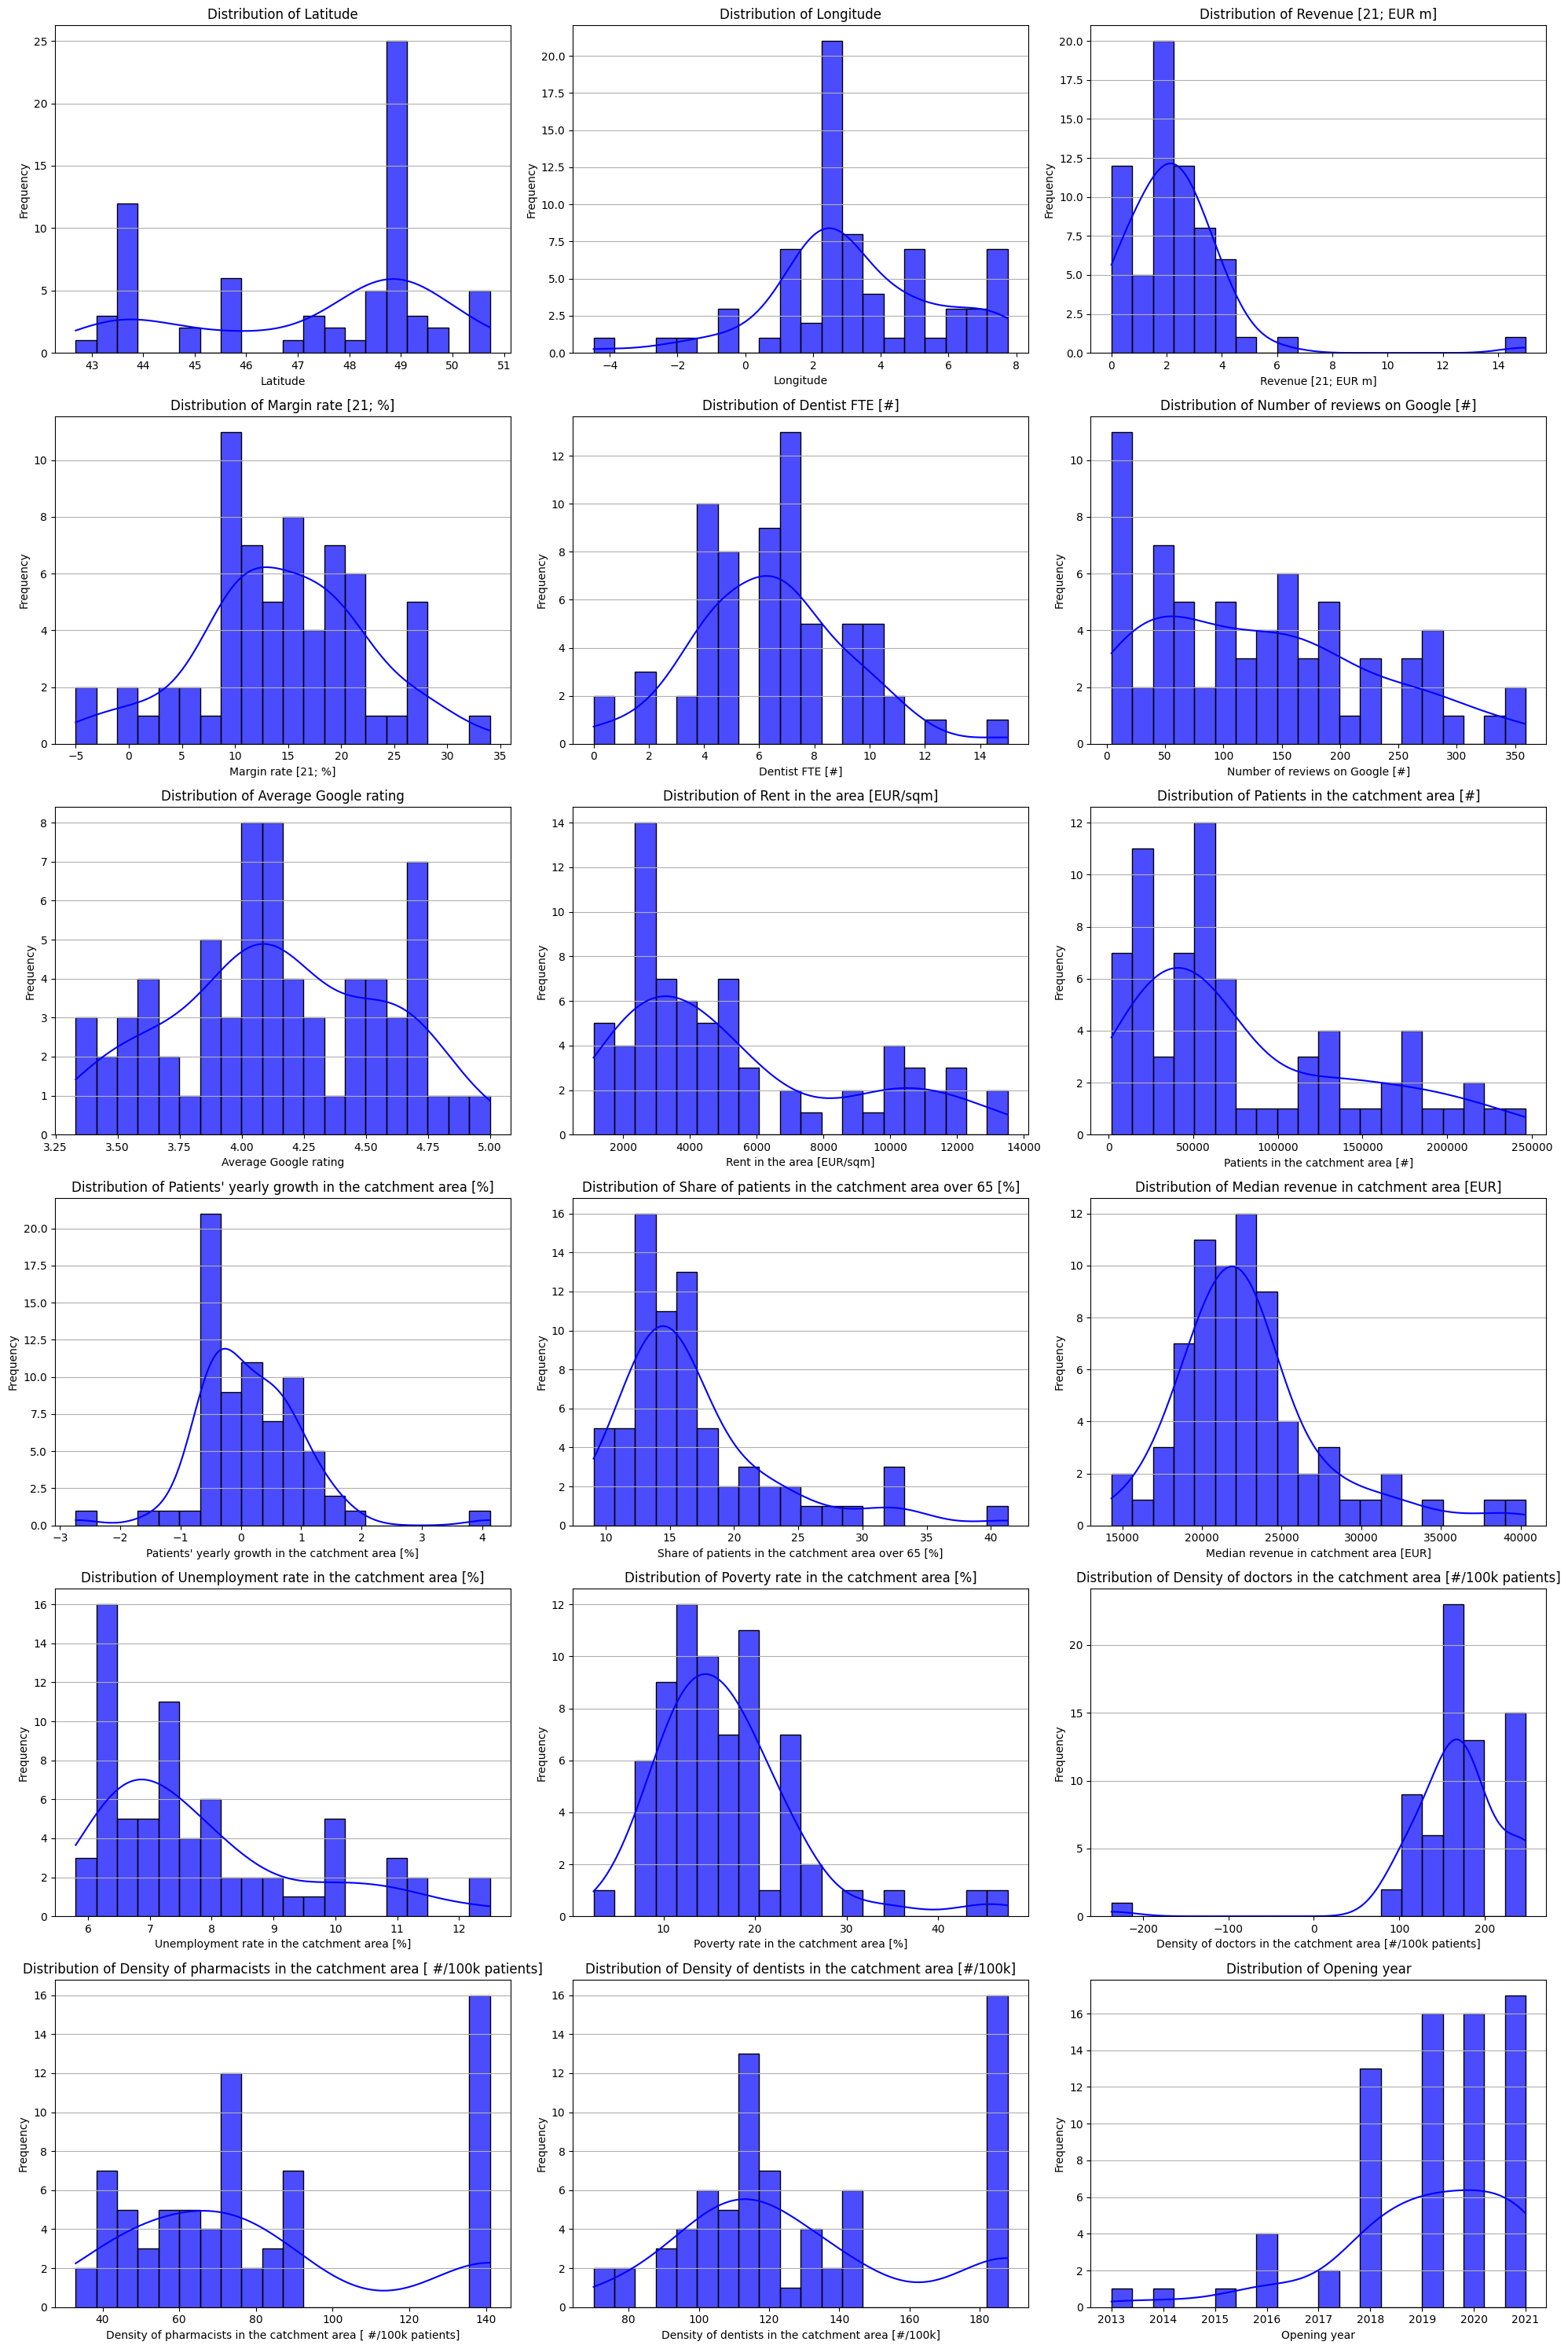

In [9]:
n_cols = 3
n_rows = 6

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten()

# Plotting histograms
for i, col in enumerate(df.columns):
    sns.histplot(df[col], kde=True, bins=20, color='blue', alpha=0.7, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}', fontsize=12)
    axes[i].set_xlabel(col, fontsize=10)
    axes[i].set_ylabel('Frequency', fontsize=10)
    axes[i].grid(axis='y')

plt.tight_layout()
plt.show()


From the visualizations, we observe that most distributions are relatively normal, with a few skewed ones. However, there are potential outliers in certain columns, particularly in *Density of doctors in the catchment area*, *Margin rate*, *Dentist FTE* and *Revenue*. These require closer inspection to determine their validity and appropriate handling strategies. Let’s address them separately below

##### Density of doctors in the catchment area :

In [10]:
# see neative values in the 'Density of doctors in the catchment area [#/100k patients]' column
df[df['Density of doctors in the catchment area [#/100k patients]'] < 0]

Latitude  Longitude  Revenue [21; EUR m]  Margin rate [21; %]  \
ID                                                                   
10  49.183878  -0.362323                  2.2                  9.0   

    Dentist FTE [#]  Number of reviews on Google [#]  Average Google rating  \
ID                                                                            
10              6.0                            199.0               4.316583   

    Rent in the area [EUR/sqm]  Patients in the catchment area [#]  \
ID                                                                   
10                        3459                        27532.624233   

    Patients' yearly growth in the catchment area [%]  \
ID                                                      
10                                              -0.32   

    Share of patients in the catchment area over 65 [%]  \
ID                                                        
10                                          15.541685     

    Median revenue in catchment area [EUR]  \
ID                                           
10                                 22510.0   

    Unemployment rate in the catchment area [%]  \
ID                                                
10                                          7.2   

    Poverty rate in the catchment area [%]  \
ID                                           
10                               10.087484   

    Density of doctors in the catchment area [#/100k patients]  \
ID                                                               
10                                             -237.0            

    Density of pharmacists in the catchment area [ #/100k patients]  \
ID                                                                    
10                                                 47                 

    Density of dentists in the catchment area [#/100k]  Opening year  
ID                                                                    
10                                                106           2020

This column have a negative value, we should replace it with a NaN value, then we will impute it later

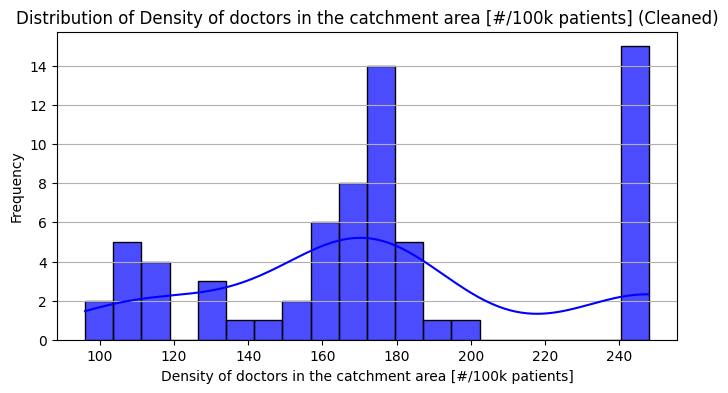

In [11]:
# Replace negative values in 'Density of doctors in the catchment area [#/100k patients]' with NaN
df.loc[df['Density of doctors in the catchment area [#/100k patients]'] < 0, 
       'Density of doctors in the catchment area [#/100k patients]'] = None

# Replotting the distribution for the cleaned 'Density of doctors in the catchment area [#/100k patients]' column
plt.figure(figsize=(8, 4))
sns.histplot(df['Density of doctors in the catchment area [#/100k patients]'], kde=True, bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Density of doctors in the catchment area [#/100k patients] (Cleaned)', fontsize=12)
plt.xlabel('Density of doctors in the catchment area [#/100k patients]', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.grid(axis='y')
plt.show()



This new distribution appears more realistic and aligns with expectations, as it only contains valid data points. This cleaned column is ready for further analysis or imputation of missing values.

Since we can already see that 'Density of doctors in the catchment area', 'Density of pharmacists in the catchment area', and 'Density of dentists in the catchment area' columns share similar distributions, we might later consider using their relationships for advanced imputation methods

##### Margin rate :

Next, we address potential outliers in the Margin rate [21; %] column. This column has a few negative values, which are unusual for profit margins. These need to be closely examined and replaced, as negative profit margins might indicate data entry errors or rare cases requiring adjustments. Let's identify and address these outliers.

In [12]:
# first, let's see negative values
df[df['Margin rate [21; %]'] < 0]

Latitude  Longitude  Revenue [21; EUR m]  Margin rate [21; %]  \
ID                                                                   
39  47.900192   1.903934                  0.2                 -4.0   
56  49.256130   4.028529                  1.0                 -1.0   
59  49.440457   1.092649                  1.0                 -1.0   
60  49.845012   3.290347                  0.0                 -5.0   

    Dentist FTE [#]  Number of reviews on Google [#]  Average Google rating  \
ID                                                                            
39              0.0                             13.0               4.384615   
56              8.0                             47.0               4.191489   
59              2.0                             35.0               4.057143   
60              0.0                              NaN                    NaN   

    Rent in the area [EUR/sqm]  Patients in the catchment area [#]  \
ID                                                                   
39                        3180                        41236.331310   
56                        2496                        51981.049447   
59                        2910                        55676.855595   
60                        1121                        25053.139562   

    Patients' yearly growth in the catchment area [%]  \
ID                                                      
39                                               0.32   
56                                              -0.04   
59                                               0.11   
60                                              -0.67   

    Share of patients in the catchment area over 65 [%]  \
ID                                                        
39                                          15.693035     
56                                          14.317091     
59                                          13.800621     
60                                          19.469618     

    Median revenue in catchment area [EUR]  \
ID                                           
39                            21684.230769   
56                            22407.586207   
59                            22664.074074   
60                            17883.809524   

    Unemployment rate in the catchment area [%]  \
ID                                                
39                                          7.5   
56                                          7.6   
59                                          8.9   
60                                          6.0   

    Poverty rate in the catchment area [%]  \
ID                                           
39                               15.439715   
56                               11.877046   
59                               18.664379   
60                               22.908162   

    Density of doctors in the catchment area [#/100k patients]  \
ID                                                               
39                                              110.0            
56                                              152.0            
59                                              149.0            
60                                              110.0            

    Density of pharmacists in the catchment area [ #/100k patients]  \
ID                                                                    
39                                                 41                 
56                                                 64                 
59                                                 43                 
60                                                 42                 

    Density of dentists in the catchment area [#/100k]  Opening year  
ID                                                                    
39                                                102           2019  
56                                                118           2020  
59                   

We can observe that :

ID 39, 56, 59, and 60 have negative margin rates ranging from -0.01 to -0.05.
These values are unusual since profit margins are generally positive.

Potential Indicators:

-- ID 60 has a revenue of 0, which might indicate a non-operational center (since it is not a newly established center (opened in 2016)).

-- ID 39 and 60 have no active dentists (Dentist FTE [#] = 0), further supporting the possibility of non-operational centers.

-- ID 60 lacks reviews and ratings, which is consistent with a non-operational center.


These negative values do not appear to be outright mistakes. Instead, they likely indicate that the costs of these centers exceeded their revenues during that year, leading to negative margins. This could be a result of operational inefficiencies or other financial challenges. Since these values provide insights into underperforming centers, we will retain them in the dataset without modification. They can be easily filtered for specific analysis in the future if needed.

##### Dentist FTE

Next, we address the 'Dentist FTE [#]' column, which contains some 0 values. A Dentist FTE of 0 indicates that no active dentists are present at a center, which might represent non-operational centers, centers undergoing restructuring, or data inconsistencies. Let’s examine these cases further to decide how to handle them.

In [13]:
df[df['Dentist FTE [#]'] <= 0]

Latitude  Longitude  Revenue [21; EUR m]  Margin rate [21; %]  \
ID                                                                   
39  47.900192   1.903934                  0.2                 -4.0   
60  49.845012   3.290347                  0.0                 -5.0   

    Dentist FTE [#]  Number of reviews on Google [#]  Average Google rating  \
ID                                                                            
39              0.0                             13.0               4.384615   
60              0.0                              NaN                    NaN   

    Rent in the area [EUR/sqm]  Patients in the catchment area [#]  \
ID                                                                   
39                        3180                        41236.331310   
60                        1121                        25053.139562   

    Patients' yearly growth in the catchment area [%]  \
ID                                                      
39                                               0.32   
60                                              -0.67   

    Share of patients in the catchment area over 65 [%]  \
ID                                                        
39                                          15.693035     
60                                          19.469618     

    Median revenue in catchment area [EUR]  \
ID                                           
39                            21684.230769   
60                            17883.809524   

    Unemployment rate in the catchment area [%]  \
ID                                                
39                                          7.5   
60                                          6.0   

    Poverty rate in the catchment area [%]  \
ID                                           
39                               15.439715   
60                               22.908162   

    Density of doctors in the catchment area [#/100k patients]  \
ID                                                               
39                                              110.0            
60                                              110.0            

    Density of pharmacists in the catchment area [ #/100k patients]  \
ID                                                                    
39                                                 41                 
60                                                 42                 

    Density of dentists in the catchment area [#/100k]  Opening year  
ID                                                                    
39                                                102           2019  
60                                                 94           2016

The Dentist FTE [#] column shows two centers (ID 39 and ID 60) with no active dentists. These cases likely represent non-operational or temporarily inactive centers. We will retain these values as they provide insights into underperforming or inactive centers. However, their impact on subsequent analysis will need to be considered.

##### Revenue :

Next, we address the 'Revenue [21; EUR m]' column, which contains some 0 values as well as unusually high values (15). A revenue of 0 likely represents non-operational centers or centers that did not generate income in 2021, while a revenue of 15 might indicate exceptional performance or a reporting inconsistency. Let’s generate descriptive statistics for the dataset to better understand the overall distribution and guide our handling strategy for these cases.

In [14]:
df[(df['Revenue [21; EUR m]'] == 0) | (df['Revenue [21; EUR m]'] == 15)]

Latitude  Longitude  Revenue [21; EUR m]  Margin rate [21; %]  \
ID                                                                   
15  45.779301   3.081492                  0.0                 10.0   
29  43.303751   5.368211                  0.0                  1.0   
60  49.845012   3.290347                  0.0                 -5.0   
69  50.360704   3.525183                  0.0                 20.0   
70  50.616725   3.133466                 15.0                 19.0   

    Dentist FTE [#]  Number of reviews on Google [#]  Average Google rating  \
ID                                                                            
15              2.0                              7.0               4.714286   
29              5.0                              NaN                    NaN   
60              0.0                              NaN                    NaN   
69              2.0                              8.0               4.500000   
70              4.0                             46.0               4.891304   

    Rent in the area [EUR/sqm]  Patients in the catchment area [#]  \
ID                                                                   
15                        2469                        55915.371810   
29                        3087                        74590.427964   
60                        1121                        25053.139562   
69                        1871                        22191.019956   
70                        3484                        24675.533216   

    Patients' yearly growth in the catchment area [%]  \
ID                                                      
15                                               0.73   
29                                               0.30   
60                                              -0.67   
69                                               0.26   
70                                               0.04   

    Share of patients in the catchment area over 65 [%]  \
ID                                                        
15                                          17.044792     
29                                          15.303172     
60                                          19.469618     
69                                          17.224097     
70                                           9.059540     

    Median revenue in catchment area [EUR]  \
ID                                           
15                            21461.785714   
29                            14587.500000   
60                            17883.809524   
69                            19425.882353   
70                            18853.333333   

    Unemployment rate in the catchment area [%]  \
ID                                                
15                                          7.0   
29                                          9.4   
60                                          6.0   
69                                         10.1   
70                                         10.1   

    Poverty rate in the catchment area [%]  \
ID                                           
15                                     NaN   
29                               43.919041   
60                               22.908162   
69                               19.539536   
70                               23.194949   

    Density of doctors in the catchment area [#/100k patients]  \
ID                                                               
15                                              158.0            
29                                              183.0            
60                                              110.0            
69                                              166.0            
70                                              166.0            

    Density of pharmacists in the catchment area [ #/100k patients]  \
ID                                                                    
15                                            

From the filtered data, we observe that centers with Revenue = 0 likely represent underperforming or non-operational centers, as they have few or no active dentists and minimal engagement (low reviews and ratings). On the other hand, the center with Revenue = 15 stands out with exceptional performance and warrants further investigation to determine if this value is consistent with its characteristics.

Let’s investigate the center with Revenue = 15 by comparing it to other centers based on their geographical proximity, as well as their operational characteristics, such as the number of active dentists, patients in the catchment area, and ratings. This analysis will help assess whether this revenue value is logical or an outlier.

###### Geograpohical Analysis

In [15]:
# Coordinates of ID 70
reference_coords = (df.loc[70, 'Latitude'], df.loc[70, 'Longitude'])

df_with_dst = df.copy()
# Calculate distances of all centers from ID 70
df_with_dst['Distance_from_70'] = df_with_dst.apply(
    lambda row: geodesic(reference_coords, (row['Latitude'], row['Longitude'])).kilometers, axis=1
)

# Filter centers within 15 km of ID 70
nearby_centers = df_with_dst[df_with_dst['Distance_from_70'] <= 15].sort_values(by='Distance_from_70')

#map of centers within 15 km of ID 70
map_70= folium.Map(location=[df.loc[70, 'Latitude'], df.loc[70, 'Longitude']], zoom_start=11)
marker_cluster = MarkerCluster().add_to(map_70)
for idx, row in nearby_centers.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"ID: {idx}<br>Revenue: {row['Revenue [21; EUR m]']} M EUR<br>Margin Rate: {row['Margin rate [21; %]']}%",
        tooltip=f"Center ID: {idx}<br>Revenue: {row['Revenue [21; EUR m]']} M EUR "
    ).add_to(marker_cluster)
map_70


In [16]:
nearby_centers

Latitude  Longitude  Revenue [21; EUR m]  Margin rate [21; %]  \
ID                                                                   
70  50.616725   3.133466                 15.0                 19.0   
23  50.635571   3.058779                  1.8                 10.0   
58  50.692226   3.176593                  1.6                  5.0   
67  50.725329   3.156516                  3.0                 20.0   

    Dentist FTE [#]  Number of reviews on Google [#]  Average Google rating  \
ID                                                                            
70              4.0                             46.0               4.891304   
23              6.0                            261.0               3.651341   
58              7.0                            158.0               4.018987   
67              7.0                            156.0               3.852564   

    Rent in the area [EUR/sqm]  Patients in the catchment area [#]  \
ID                                                                   
70                        3484                        24675.533216   
23                        4200                        73609.077960   
58                        1359                        55931.469617   
67                        1924                        55181.794469   

    Patients' yearly growth in the catchment area [%]  \
ID                                                      
70                                               0.04   
23                                               0.14   
58                                               0.46   
67                                               0.73   

    Share of patients in the catchment area over 65 [%]  \
ID                                                        
70                                           9.059540     
23                                           9.071684     
58                                           9.996912     
67                                          11.940397     

    Median revenue in catchment area [EUR]  \
ID                                           
70                            18853.333333   
23                            22093.846154   
58                            14317.058824   
67                            17260.625000   

    Unemployment rate in the catchment area [%]  \
ID                                                
70                                         10.1   
23                                         10.1   
58                                         10.1   
67                                         10.1   

    Poverty rate in the catchment area [%]  \
ID                                           
70                               23.194949   
23                               18.707482   
58                               47.600799   
67                               26.477449   

    Density of doctors in the catchment area [#/100k patients]  \
ID                                                               
70                                              166.0            
23                                              166.0            
58                                              166.0            
67                                              166.0            

    Density of pharmacists in the catchment area [ #/100k patients]  \
ID                                                                    
70                                                 55                 
23                                                 55                 
58                                                 55                 
67                                                 55                 

    Density of dentists in the catchment area [#/100k]  Opening year  \
ID                                                                     
70                                                113           2019   
23                                                113           2019   
58               

From the geographical analysis, ID 70 appears to be a clear outlier. Nearby centers within 15 km show significantly lower revenues, suggesting that ID 70's exceptional performance is either due to unique operational factors or potential inconsistencies in the reported data. Further investigation into operational characteristics is required to validate this observation.

###### Operational Analysis

Now, let's investigate its operational characteristics in comparison to other centers. This includes examining the number of active dentists, the patient base, and customer engagement metrics like Google reviews and ratings. By comparing these elements, we can further validate whether the reported revenue is logical.

In [17]:
reference_center = df.loc[70]

fte_margin = 2  # Allow a margin of ±2 for Dentist FTE

# Filter for operationally similar centers with reasonable margins
operational_similar = df[
    (df['Dentist FTE [#]'] >= reference_center['Dentist FTE [#]'] - fte_margin) &
    (df['Dentist FTE [#]'] <= reference_center['Dentist FTE [#]'] + fte_margin) &
    (df['Patients in the catchment area [#]'] >= reference_center['Patients in the catchment area [#]'] * 0.8) &
    (df['Patients in the catchment area [#]'] <= reference_center['Patients in the catchment area [#]'] * 1.2) &
    (df['Average Google rating'] >= 4.0) &
    (df['Number of reviews on Google [#]'] >= 40)
]

# Sort by revenue for comparison
operational_similar.sort_values(by='Revenue [21; EUR m]', ascending=False)[['Revenue [21; EUR m]', 'Dentist FTE [#]', 'Patients in the catchment area [#]', 'Average Google rating', 'Number of reviews on Google [#]']]


Revenue [21; EUR m]  Dentist FTE [#]  Patients in the catchment area [#]  \
ID                                                                             
70                 15.0              4.0                        24675.533216   
10                  2.2              6.0                        27532.624233   
14                  1.6              4.0                        25030.600363   

    Average Google rating  Number of reviews on Google [#]  
ID                                                          
70               4.891304                             46.0  
10               4.316583                            199.0  
14               4.136986                             73.0

Based on the operational analysis, we observe that ID 70’s revenue of 15 million EUR is a clear outlier. For example, clinic ID 10, which has similar operational characteristics (comparable Dentist FTE and patients in the catchment area) but higher engagement metrics (more Google reviews), a more affluent catchment area (higher median income and lower unemployment rate), and a larger share of older patients, only generates 2.2 million EUR in revenue. This further reinforces that ID 70's revenue does not align with its operational or geographical context.

###### Handling this outlier

From both the geographical and operational analyses, it is evident that the revenue value for ID 70 is an outlier. To ensure the integrity of the dataset, we will replace this value with NaN for now and address its correction later during the imputation phase.

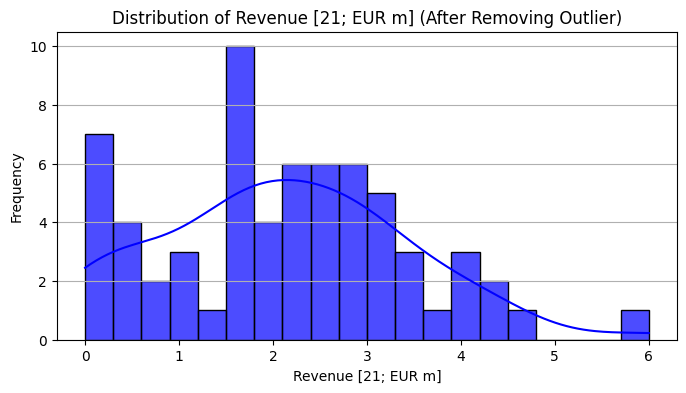

In [18]:
df.loc[70, 'Revenue [21; EUR m]'] = None

# see the distribution of the 'Revenue [21; EUR m]' column after removing the outlier
plt.figure(figsize=(8, 4))
sns.histplot(df['Revenue [21; EUR m]'], kde=True, bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Revenue [21; EUR m] (After Removing Outlier)', fontsize=12)
plt.xlabel('Revenue [21; EUR m]', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.grid(axis='y')
plt.show()

#### Exploring the correlation between variables

Before starting handling missing values, we will see the correlations between different variables, sos that we will treat each missing value based on domain-knowledge.

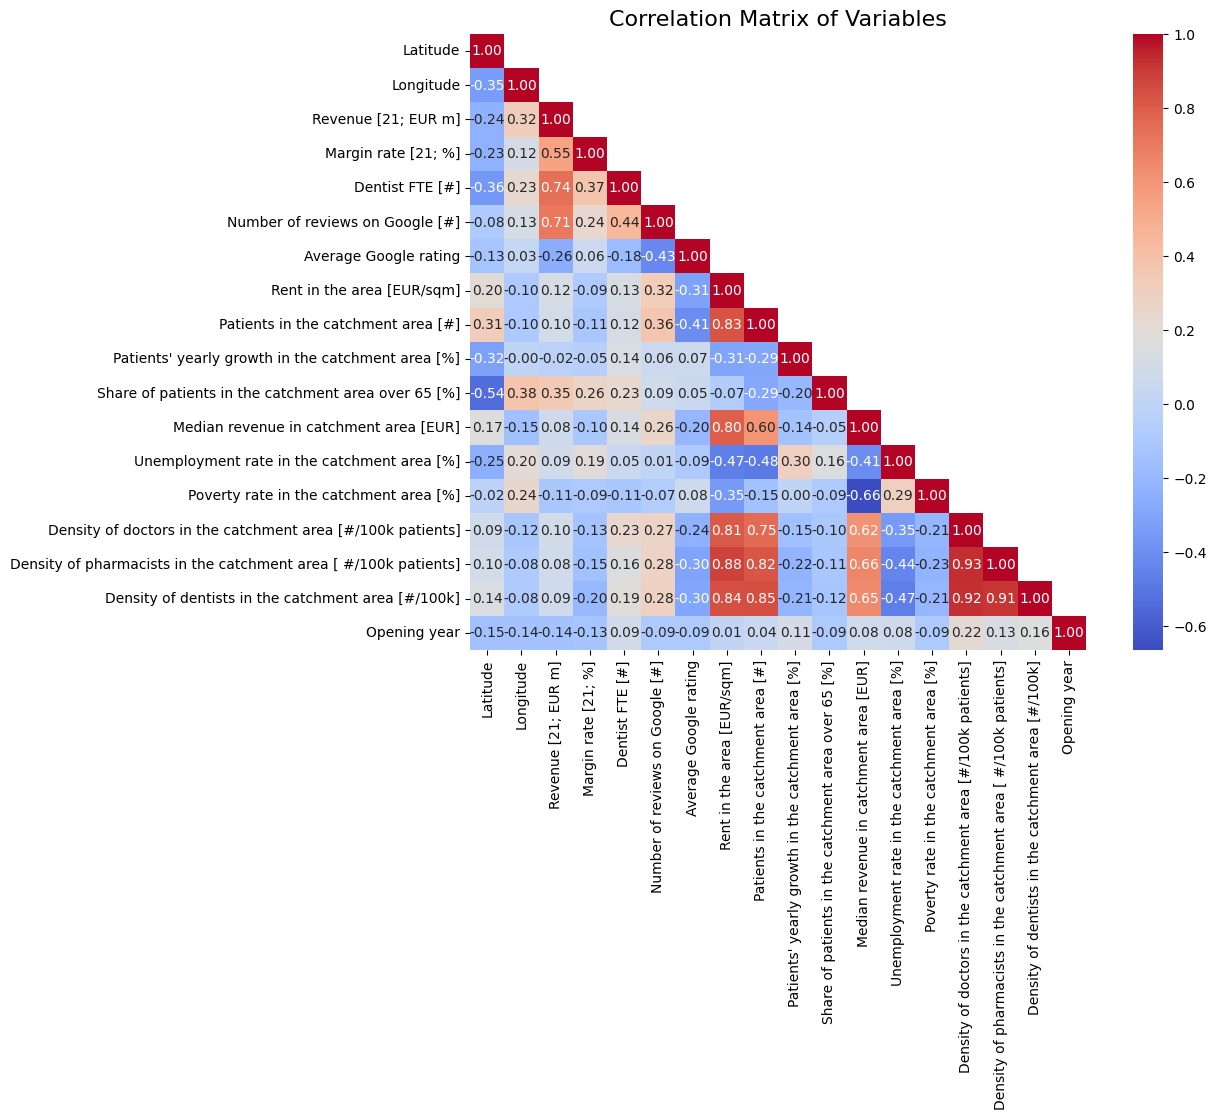

In [19]:
# Compute the correlation matrix
correlation_matrix = df.corr()

# Plotting a heatmap to visualize correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, mask=np.triu(correlation_matrix, k=1))
plt.title("Correlation Matrix of Variables", fontsize=16)
plt.show()




This correlation matrix provides valuable insights into the relationships between variables. For example, we can observe that the three density-related columns (Density of doctors, Density of pharmacists, and Density of dentists) are strongly correlated. This relationship will be particularly useful when imputing missing values, as one density metric can help estimate another if data is missing.

#### Handling Missing Values

Let's now handle the missing values

In [20]:
# Count of missing values per column
df.isnull().sum()[df.isnull().sum() > 0].sort_values()


Patients in the catchment area [#]                            1
Unemployment rate in the catchment area [%]                   1
Poverty rate in the catchment area [%]                        1
Number of reviews on Google [#]                               3
Average Google rating                                         3
Density of doctors in the catchment area [#/100k patients]    3
Margin rate [21; %]                                           5
Dentist FTE [#]                                               5
Revenue [21; EUR m]                                           6
dtype: int64

The above output highlights the columns with missing values and their respective counts. Each column will be treated independently, depending on its context and use case, starting with those with less missing values.

##### Handling 'Patients in the catchment area' missing values

In [21]:
# see the row with missing values in Patients in the catchment area [#] column
df[df['Patients in the catchment area [#]'].isnull()]

Latitude  Longitude  Revenue [21; EUR m]  Margin rate [21; %]  \
ID                                                                   
57  48.105363  -1.677937                  0.7                 15.0   

    Dentist FTE [#]  Number of reviews on Google [#]  Average Google rating  \
ID                                                                            
57              4.0                             94.0               4.691489   

    Rent in the area [EUR/sqm]  Patients in the catchment area [#]  \
ID                                                                   
57                        4736                                 NaN   

    Patients' yearly growth in the catchment area [%]  \
ID                                                      
57                                               0.59   

    Share of patients in the catchment area over 65 [%]  \
ID                                                        
57                                          14.259224     

    Median revenue in catchment area [EUR]  \
ID                                           
57                                 23574.5   

    Unemployment rate in the catchment area [%]  \
ID                                                
57                                          5.8   

    Poverty rate in the catchment area [%]  \
ID                                           
57                               10.605591   

    Density of doctors in the catchment area [#/100k patients]  \
ID                                                               
57                                              158.0            

    Density of pharmacists in the catchment area [ #/100k patients]  \
ID                                                                    
57                                                 64                 

    Density of dentists in the catchment area [#/100k]  Opening year  
ID                                                                    
57                                                101           2020

From the correlation matrix, we observe that 'Patients in the catchment area [#]' is strongly correlated with 'Rent in the area [EUR/sqm]' (0.83), 'Density of pharmacists in the catchment area [#/100k patients]' (0.82), and 'Density of dentists in the catchment area [#/100k] (0.85)'. Therefore, we will use these variables together in a multiple linear regression model to impute the missing value for ID 57 in the Patients in the catchment area column.

In [22]:
# Let's build a small regression model to impute the missing value for ID 57

valid_data = df[['Rent in the area [EUR/sqm]', 
                 'Density of pharmacists in the catchment area [ #/100k patients]', 
                 'Density of dentists in the catchment area [#/100k]', 
                 'Patients in the catchment area [#]']].dropna()

# Predictor variables and target variable
X = valid_data[['Rent in the area [EUR/sqm]', 
                'Density of pharmacists in the catchment area [ #/100k patients]', 
                'Density of dentists in the catchment area [#/100k]']]
y = valid_data['Patients in the catchment area [#]']

# Train the regression model
reg_model = LinearRegression()
reg_model.fit(X, y)

# Predict the missing value for ID 57
missing_row_features = df.loc[[57], ['Rent in the area [EUR/sqm]', 
                                     'Density of pharmacists in the catchment area [ #/100k patients]', 
                                     'Density of dentists in the catchment area [#/100k]']]
predicted_value = reg_model.predict(missing_row_features)

# Impute the missing value
df.loc[57, 'Patients in the catchment area [#]'] = predicted_value[0]

#### Handling 'Unemployment rate in the catchment area' missing values

In [23]:
# see the row with missing values
df[df['Unemployment rate in the catchment area [%]'].isnull()]

Latitude  Longitude  Revenue [21; EUR m]  Margin rate [21; %]  \
ID                                                                   
31  43.773873   7.500619                  1.6                  9.0   

    Dentist FTE [#]  Number of reviews on Google [#]  Average Google rating  \
ID                                                                            
31              6.0                             90.0                    4.7   

    Rent in the area [EUR/sqm]  Patients in the catchment area [#]  \
ID                                                                   
31                        5089                        12573.245987   

    Patients' yearly growth in the catchment area [%]  \
ID                                                      
31                                               1.47   

    Share of patients in the catchment area over 65 [%]  \
ID                                                        
31                                          32.962261     

    Median revenue in catchment area [EUR]  \
ID                                           
31                                 21270.0   

    Unemployment rate in the catchment area [%]  \
ID                                                
31                                          NaN   

    Poverty rate in the catchment area [%]  \
ID                                           
31                               15.734146   

    Density of doctors in the catchment area [#/100k patients]  \
ID                                                               
31                                              199.0            

    Density of pharmacists in the catchment area [ #/100k patients]  \
ID                                                                    
31                                                 71                 

    Density of dentists in the catchment area [#/100k]  Opening year  
ID                                                                    
31                                                130           2020

To impute the missing value in the Unemployment rate in the catchment area column for ID 31, we will use a similarity-based approach. Specifically, we will identify rows with similar values for 3 most related features: Poverty rate in the catchment area [%], Rent in the area [EUR/sqm], and Density of dentists in the catchment area [#/100k]. By selecting centers with close values for these columns, we can calculate an average unemployment rate to impute the missing value logically.

In [24]:
# look for row with close values in the 'Poverty rate in the catchment area [%]' and close values in the 
# 'Rent in the area [EUR/sqm]' column and 'Density of dentists in the catchment area [#/100k]' column
pov_rate = df.loc[31, 'Poverty rate in the catchment area [%]']
rent_rate = df.loc[31, 'Rent in the area [EUR/sqm]']
dens_dentists = df.loc[31, 'Density of dentists in the catchment area [#/100k]']

# Filter centers with similar poverty rates
filtered_df = df[df['Poverty rate in the catchment area [%]'].between(pov_rate - 5, pov_rate + 5) & 
   df['Rent in the area [EUR/sqm]'].between(rent_rate - 1000, rent_rate + 1000) & 
   df['Density of dentists in the catchment area [#/100k]'].between(dens_dentists - 15, dens_dentists + 15) ]

filtered_df[['Poverty rate in the catchment area [%]', 'Rent in the area [EUR/sqm]', 'Density of dentists in the catchment area [#/100k]', 'Unemployment rate in the catchment area [%]']]


Poverty rate in the catchment area [%]  Rent in the area [EUR/sqm]  \
ID                                                                       
6                                13.676555                        6007   
25                               13.144815                        5117   
26                               13.212571                        4806   
28                               12.317151                        5503   
31                               15.734146                        5089   
36                               20.218534                        5142   
62                               18.587686                        5293   
66                               15.468347                        4941   
71                               14.731955                        4711   

    Density of dentists in the catchment area [#/100k]  \
ID                                                       
6                                                 121    
25                                                144    
26                                                144    
28                                                144    
31                                                130    
36                                                134    
62                                                117    
66                                                116    
71                                                144    

    Unemployment rate in the catchment area [%]  
ID                                               
6                                           7.4  
25                                          7.2  
26                                          7.2  
28                                          7.2  
31                                          NaN  
36                                          7.0  
62                                          8.5  
66                                          8.1  
71                                          7.2

In [25]:
avr_unemployment_rate = filtered_df['Unemployment rate in the catchment area [%]'].mean()
avr_unemployment_rate

7.475000000000001

In [26]:
# Impute the missing value

df.loc[31, 'Unemployment rate in the catchment area [%]'] = avr_unemployment_rate

#### Handling 'Poverty rate in the catchment area' missing values

In [27]:
# see the row with missing values 
df[df['Poverty rate in the catchment area [%]'].isnull()]

Latitude  Longitude  Revenue [21; EUR m]  Margin rate [21; %]  \
ID                                                                   
15  45.779301   3.081492                  0.0                 10.0   

    Dentist FTE [#]  Number of reviews on Google [#]  Average Google rating  \
ID                                                                            
15              2.0                              7.0               4.714286   

    Rent in the area [EUR/sqm]  Patients in the catchment area [#]  \
ID                                                                   
15                        2469                         55915.37181   

    Patients' yearly growth in the catchment area [%]  \
ID                                                      
15                                               0.73   

    Share of patients in the catchment area over 65 [%]  \
ID                                                        
15                                          17.044792     

    Median revenue in catchment area [EUR]  \
ID                                           
15                            21461.785714   

    Unemployment rate in the catchment area [%]  \
ID                                                
15                                          7.0   

    Poverty rate in the catchment area [%]  \
ID                                           
15                                     NaN   

    Density of doctors in the catchment area [#/100k patients]  \
ID                                                               
15                                              158.0            

    Density of pharmacists in the catchment area [ #/100k patients]  \
ID                                                                    
15                                                 78                 

    Density of dentists in the catchment area [#/100k]  Opening year  
ID                                                                    
15                                                134           2018

In [28]:
# see rows with  Density of pharmacists in the catchment area [ #/100k patients] equal to 78
df[df['Density of pharmacists in the catchment area [ #/100k patients]'] == 
   df.loc[15, 'Density of pharmacists in the catchment area [ #/100k patients]']][['Unemployment rate in the catchment area [%]',
                                                                                  'Poverty rate in the catchment area [%]',
                                                                                  'Density of doctors in the catchment area [#/100k patients]',
                                                                                 'Density of pharmacists in the catchment area [ #/100k patients]',
                                                                              	'Density of dentists in the catchment area [#/100k]',
                                                                                 'Opening year']]




Unemployment rate in the catchment area [%]  \
ID                                                
15                                          7.0   
36                                          7.0   

    Poverty rate in the catchment area [%]  \
ID                                           
15                                     NaN   
36                               20.218534   

    Density of doctors in the catchment area [#/100k patients]  \
ID                                                               
15                                              158.0            
36                                              158.0            

    Density of pharmacists in the catchment area [ #/100k patients]  \
ID                                                                    
15                                                 78                 
36                                                 78                 

    Density of dentists in the catchment area [#/100k]  Opening year  
ID                                                                    
15                                                134           2018  
36                                                134           2018

The values for Unemployment rate in the catchment area [%], Poverty rate in the catchment area [%], Density of doctors in the catchment area [#/100k patients], Density of pharmacists in the catchment area [#/100k patients], and Density of dentists in the catchment area [#/100k] are identical between ID 15 and ID 36. This strongly suggests that these two centers are in the same catchment area. Therefore, it is reasonable to assume that the poverty rate for ID 36 (20.218534) can be used to impute the missing value for ID 15.

In [29]:
# impute the missing value

df.loc[15, 'Poverty rate in the catchment area [%]'] = df.loc[36, 'Poverty rate in the catchment area [%]']

#### Handling 'Number of reviews on Google' and 'Average Google rating' missing values

To handle the missing values in the Number of reviews on Google and Average Google rating columns, a possible approach would be to perform a web search (or automate it using web scraping) for each center to extract accurate data. However, due to time constraints, I will proceed with imputing the missing values using a KNN approach. This method will consider the most correlated columns, such as Patients in the catchment area [#] and Density of dentists in the catchment area [#/100k] to predict the missing values.

In [30]:
# see the row with missing values 
df[df['Number of reviews on Google [#]'].isnull()]

Latitude  Longitude  Revenue [21; EUR m]  Margin rate [21; %]  \
ID                                                                   
29  43.303751   5.368211                  0.0                  1.0   
38  43.838278   4.363345                  NaN                  NaN   
60  49.845012   3.290347                  0.0                 -5.0   

    Dentist FTE [#]  Number of reviews on Google [#]  Average Google rating  \
ID                                                                            
29              5.0                              NaN                    NaN   
38              NaN                              NaN                    NaN   
60              0.0                              NaN                    NaN   

    Rent in the area [EUR/sqm]  Patients in the catchment area [#]  \
ID                                                                   
29                        3087                        74590.427964   
38                        1988                        55887.755483   
60                        1121                        25053.139562   

    Patients' yearly growth in the catchment area [%]  \
ID                                                      
29                                               0.30   
38                                              -0.12   
60                                              -0.67   

    Share of patients in the catchment area over 65 [%]  \
ID                                                        
29                                          15.303172     
38                                          21.732715     
60                                          19.469618     

    Median revenue in catchment area [EUR]  \
ID                                           
29                            14587.500000   
38                            18604.666667   
60                            17883.809524   

    Unemployment rate in the catchment area [%]  \
ID                                                
29                                          9.4   
38                                         11.0   
60                                          6.0   

    Poverty rate in the catchment area [%]  \
ID                                           
29                               43.919041   
38                               25.542045   
60                               22.908162   

    Density of doctors in the catchment area [#/100k patients]  \
ID                                                               
29                                              183.0            
38                                              150.0            
60                                              110.0            

    Density of pharmacists in the catchment area [ #/100k patients]  \
ID                                                                    
29                                                 88                 
38                                                 72                 
60                                                 42                 

    Density of dentists in the catchment area [#/100k]  Opening year  
ID                                                                    
29                                                134           2017  
38                                                114           2021  
60                                                 94           2016

In [31]:
# Selecting features relevant for KNN imputation
knn_features = df[['Average Google rating', 
                   'Number of reviews on Google [#]', 
                   'Patients in the catchment area [#]',
                   'Density of dentists in the catchment area [#/100k]']]

# Initialize KNN imputer
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform')

# Apply KNN imputation
knn_imputed = knn_imputer.fit_transform(knn_features)

# Update the dataset with imputed values
df['Average Google rating'] = knn_imputed[:, 0]
df['Number of reviews on Google [#]'] = knn_imputed[:, 1]

#### Handling 'Density of doctors in the catchment area' missing values

In [32]:
# see the row with missing values 
df[df['Density of doctors in the catchment area [#/100k patients]'].isnull()]

Latitude  Longitude  Revenue [21; EUR m]  Margin rate [21; %]  \
ID                                                                   
10  49.183878  -0.362323                  2.2                  9.0   
49  48.890494   2.360228                  1.5                  6.0   
62  43.421179   6.769466                  4.4                 28.0   

    Dentist FTE [#]  Number of reviews on Google [#]  Average Google rating  \
ID                                                                            
10              6.0                            199.0               4.316583   
49              5.0                            142.0               3.345070   
62              8.0                            132.0               4.128788   

    Rent in the area [EUR/sqm]  Patients in the catchment area [#]  \
ID                                                                   
10                        3459                        27532.624233   
49                        8680                       202980.534449   
62                        5293                        14003.466783   

    Patients' yearly growth in the catchment area [%]  \
ID                                                      
10                                              -0.32   
49                                              -0.49   
62                                              -2.74   

    Share of patients in the catchment area over 65 [%]  \
ID                                                        
10                                          15.541685     
49                                          12.187049     
62                                          41.315940     

    Median revenue in catchment area [EUR]  \
ID                                           
10                               22510.000   
49                               22705.800   
62                               21404.375   

    Unemployment rate in the catchment area [%]  \
ID                                                
10                                          7.2   
49                                          6.4   
62                                          8.5   

    Poverty rate in the catchment area [%]  \
ID                                           
10                               10.087484   
49                               23.005147   
62                               18.587686   

    Density of doctors in the catchment area [#/100k patients]  \
ID                                                               
10                                                NaN            
49                                                NaN            
62                                                NaN            

    Density of pharmacists in the catchment area [ #/100k patients]  \
ID                                                                    
10                                                 47                 
49                                                141                 
62                                                 75                 

    Density of dentists in the catchment area [#/100k]  Opening year  
ID                                                                    
10                                                106           2020  
49                                                188           2021  
62                                                117           2021

There are 3 values to impute

Firt, let's adress the ID 49.

In [33]:
#See all rows that have identical values in the 'Density of pharmacists in the catchment area [ #/100k patients]' column as the one is the row ID 49

df[df['Density of pharmacists in the catchment area [ #/100k patients]'] == 
   df.loc[49, 'Density of pharmacists in the catchment area [ #/100k patients]']][["Patients' yearly growth in the catchment area [%]", 'Unemployment rate in the catchment area [%]', 'Poverty rate in the catchment area [%]', 'Density of doctors in the catchment area [#/100k patients]', 'Density of pharmacists in the catchment area [ #/100k patients]', 'Density of dentists in the catchment area [#/100k]']]

Patients' yearly growth in the catchment area [%]  \
ID                                                      
20                                              -0.49   
40                                              -0.49   
41                                              -0.49   
42                                              -0.49   
43                                              -0.49   
44                                              -0.49   
45                                              -0.49   
46                                              -0.49   
47                                              -0.49   
48                                              -0.49   
49                                              -0.49   
50                                              -0.49   
51                                              -0.49   
52                                              -0.49   
53                                              -0.49   
54                                              -0.49   

    Unemployment rate in the catchment area [%]  \
ID                                                
20                                          6.4   
40                                          6.4   
41                                          6.4   
42                                          6.4   
43                                          6.4   
44                                          6.4   
45                                          6.4   
46                                          6.4   
47                                          6.4   
48                                          6.4   
49                                          6.4   
50                                          6.4   
51                                          6.4   
52                                          6.4   
53                                          6.4   
54                                          6.4   

    Poverty rate in the catchment area [%]  \
ID                                           
20                               13.358924   
40                               17.389824   
41                               12.511394   
42                               10.846958   
43                               17.110562   
44                                9.504357   
45                                7.165592   
46                                7.014793   
47                                7.330330   
48                               18.332756   
49                               23.005147   
50                               11.651570   
51                               19.437242   
52                               15.638180   
53                               19.526397   
54                               10.308393   

    Density of doctors in the catchment area [#/100k patients]  \
ID                                                               
20                                              248.0            
40                                              248.0            
41                                              248.0            
42                                              248.0            
43                                              248.0            
44                                              248.0            
45                                              248.0            
46                                              248.0            
47                                              248.0            
48                                              248.0            
49                                                NaN            
50                                              248.0            
51                                              248.0            
52                                              248.0            
53                                              248.0            
54                                              248.0            

    Density of pharmacists in the catchm

We can see there are 15 rows that have the same Unemployment rate in the catchment area, Density of pharmacists in the catchment area and Density of dentists in the catchment area as the center with the ID 49

This means that this center is located in the same catchment area as those others.

The imputation method here then is to the value 248.0 which the value of Density of doctors in the catchment area for all 15 rows

In [34]:
# impute the missing value

df.loc[49, 'Density of doctors in the catchment area [#/100k patients]'] = 248.0

Now, let's adress the ID 62

In [35]:
#See all rows that have identical values in the 'Density of pharmacists in the catchment area [ #/100k patients]' column as the one is the row ID 49

df[df['Density of pharmacists in the catchment area [ #/100k patients]'] == 
   df.loc[62, 'Density of pharmacists in the catchment area [ #/100k patients]']]

Latitude  Longitude  Revenue [21; EUR m]  Margin rate [21; %]  \
ID                                                                   
62  43.421179   6.769466                  4.4                 28.0   
65  43.124467   5.935231                  6.0                 28.0   

    Dentist FTE [#]  Number of reviews on Google [#]  Average Google rating  \
ID                                                                            
62              8.0                            132.0               4.128788   
65             15.0                            337.0               4.115727   

    Rent in the area [EUR/sqm]  Patients in the catchment area [#]  \
ID                                                                   
62                        5293                        14003.466783   
65                        2580                        55917.523729   

    Patients' yearly growth in the catchment area [%]  \
ID                                                      
62                                              -2.74   
65                                               1.47   

    Share of patients in the catchment area over 65 [%]  \
ID                                                        
62                                          41.315940     
65                                          23.585472     

    Median revenue in catchment area [EUR]  \
ID                                           
62                            21404.375000   
65                            18931.621622   

    Unemployment rate in the catchment area [%]  \
ID                                                
62                                          8.5   
65                                          8.5   

    Poverty rate in the catchment area [%]  \
ID                                           
62                               18.587686   
65                               24.821025   

    Density of doctors in the catchment area [#/100k patients]  \
ID                                                               
62                                                NaN            
65                                              166.0            

    Density of pharmacists in the catchment area [ #/100k patients]  \
ID                                                                    
62                                                 75                 
65                                                 75                 

    Density of dentists in the catchment area [#/100k]  Opening year  
ID                                                                    
62                                                117           2021  
65                                                117           2021

Same, we can impute using the value of 'Density of doctors in the catchment area [#/100k patients]' for the ID 65 (166.0) since we talk about the same catchment area

In [36]:
# impute the missing value

df.loc[62, 'Density of doctors in the catchment area [#/100k patients]'] = df.loc[65, 'Density of doctors in the catchment area [#/100k patients]']

Now, let's adress the ID 10

In [37]:
#See all rows that have identical values in the 'Density of pharmacists in the catchment area [ #/100k patients]' column as the one is the row ID 49

df[df['Density of dentists in the catchment area [#/100k]'] == 
   df.loc[10, 'Density of dentists in the catchment area [#/100k]']]

Latitude  Longitude  Revenue [21; EUR m]  Margin rate [21; %]  \
ID                                                                   
10  49.183878  -0.362323                  2.2                  9.0   

    Dentist FTE [#]  Number of reviews on Google [#]  Average Google rating  \
ID                                                                            
10              6.0                            199.0               4.316583   

    Rent in the area [EUR/sqm]  Patients in the catchment area [#]  \
ID                                                                   
10                        3459                        27532.624233   

    Patients' yearly growth in the catchment area [%]  \
ID                                                      
10                                              -0.32   

    Share of patients in the catchment area over 65 [%]  \
ID                                                        
10                                          15.541685     

    Median revenue in catchment area [EUR]  \
ID                                           
10                                 22510.0   

    Unemployment rate in the catchment area [%]  \
ID                                                
10                                          7.2   

    Poverty rate in the catchment area [%]  \
ID                                           
10                               10.087484   

    Density of doctors in the catchment area [#/100k patients]  \
ID                                                               
10                                                NaN            

    Density of pharmacists in the catchment area [ #/100k patients]  \
ID                                                                    
10                                                 47                 

    Density of dentists in the catchment area [#/100k]  Opening year  
ID                                                                    
10                                                106           2020

Since there is no other centers in the same catchment area of the center with ID 10, we will impute the last missing value with a KNN approach based on the most relevant columns 

In [38]:
# Selecting features relevant for KNN imputation
knn_features = df[['Density of doctors in the catchment area [#/100k patients]',
                   'Rent in the area [EUR/sqm]', 'Patients in the catchment area [#]',
                   'Density of pharmacists in the catchment area [ #/100k patients]',
                   'Density of dentists in the catchment area [#/100k]']]

# Initialize KNN imputer
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform')

# Apply KNN imputation
knn_imputed = knn_imputer.fit_transform(knn_features)

# Update the dataset with imputed values
df['Density of doctors in the catchment area [#/100k patients]'] = knn_imputed[:, 0]

#### Handling 'Revenue', 'Margin rate' and 'Dentist FTE' missing values

In [39]:
# see the row with missing values 
df[df['Revenue [21; EUR m]'].isnull()]

Latitude  Longitude  Revenue [21; EUR m]  Margin rate [21; %]  \
ID                                                                   
18  48.736834   1.365297                  NaN                  NaN   
21  49.023062   1.148888                  NaN                  NaN   
30  48.959236   2.882169                  NaN                  NaN   
35  48.692024   6.181425                  NaN                  NaN   
38  43.838278   4.363345                  NaN                  NaN   
70  50.616725   3.133466                  NaN                 19.0   

    Dentist FTE [#]  Number of reviews on Google [#]  Average Google rating  \
ID                                                                            
18              NaN                             19.0               4.578947   
21              NaN                             10.0               4.700000   
30              NaN                             33.0               4.060606   
35              NaN                             14.0               4.714286   
38              NaN                            137.8               4.206229   
70              4.0                             46.0               4.891304   

    Rent in the area [EUR/sqm]  Patients in the catchment area [#]  \
ID                                                                   
18                        1590                        16206.342013   
21                        1844                        17408.129904   
30                        2870                        23423.885548   
35                        2559                        52741.353401   
38                        1988                        55887.755483   
70                        3484                        24675.533216   

    Patients' yearly growth in the catchment area [%]  \
ID                                                      
18                                              -0.46   
21                                              -1.24   
30                                               0.61   
35                                               0.16   
38                                              -0.12   
70                                               0.04   

    Share of patients in the catchment area over 65 [%]  \
ID                                                        
18                                          15.763840     
21                                          19.890533     
30                                          13.688214     
35                                          13.566230     
38                                          21.732715     
70                                           9.059540     

    Median revenue in catchment area [EUR]  \
ID                                           
18                            17016.923077   
21                            18980.000000   
30                            19556.153846   
35                            21786.206897   
38                            18604.666667   
70                            18853.333333   

    Unemployment rate in the catchment area [%]  \
ID                                                
18                                          7.2   
21                                          8.1   
30                                          7.4   
35                                          7.8   
38                                         11.0   
70                                         10.1   

    Poverty rate in the catchment area [%]  \
ID                                           
18                               24.174403   
21                               15.407340   
30                               13.890370   
35                               17.647573   
38                               25.542045   
70                               23.194949   

    Density of doctors in the catchment area [#/100k patients]  \
ID                                                               
18                                       

##### Imputing the earlier outlier

From the confusion matrix, we will use the most relevant features to impute the missing values with KNN Imputer

In [40]:
# Selecting features relevant for KNN imputation
knn_features = df[['Revenue [21; EUR m]',
                   'Margin rate [21; %]',
                   'Dentist FTE [#]']]

# Initialize KNN imputer
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform')

# Apply KNN imputation
knn_imputed = knn_imputer.fit_transform(knn_features)

# Update only the row with id 70 with the imputed value
df.loc[70, 'Revenue [21; EUR m]'] = knn_imputed[df.index.get_loc(70), 0]



Let's see the imputed value

In [41]:
df.loc[70, 'Revenue [21; EUR m]']

1.6

This imputation addresses the earlier outlier value of 15.0 in the Revenue [21; EUR m] column for ID 70. The imputed result of 1.52 suggests that our KNN-based imputation method is accurate and aligns with the context of the data. It indicates that the original value of 15.0 was likely a misentry, where 1.5 was intended. Therefore, we will consider the imputed value of 1.5 as the correct value for this cell.

In [42]:
df.loc[70, 'Revenue [21; EUR m]'] = 1.5

##### Imputing the remaining values

In [43]:
df[df['Revenue [21; EUR m]'].isnull()]

Latitude  Longitude  Revenue [21; EUR m]  Margin rate [21; %]  \
ID                                                                   
18  48.736834   1.365297                  NaN                  NaN   
21  49.023062   1.148888                  NaN                  NaN   
30  48.959236   2.882169                  NaN                  NaN   
35  48.692024   6.181425                  NaN                  NaN   
38  43.838278   4.363345                  NaN                  NaN   

    Dentist FTE [#]  Number of reviews on Google [#]  Average Google rating  \
ID                                                                            
18              NaN                             19.0               4.578947   
21              NaN                             10.0               4.700000   
30              NaN                             33.0               4.060606   
35              NaN                             14.0               4.714286   
38              NaN                            137.8               4.206229   

    Rent in the area [EUR/sqm]  Patients in the catchment area [#]  \
ID                                                                   
18                        1590                        16206.342013   
21                        1844                        17408.129904   
30                        2870                        23423.885548   
35                        2559                        52741.353401   
38                        1988                        55887.755483   

    Patients' yearly growth in the catchment area [%]  \
ID                                                      
18                                              -0.46   
21                                              -1.24   
30                                               0.61   
35                                               0.16   
38                                              -0.12   

    Share of patients in the catchment area over 65 [%]  \
ID                                                        
18                                          15.763840     
21                                          19.890533     
30                                          13.688214     
35                                          13.566230     
38                                          21.732715     

    Median revenue in catchment area [EUR]  \
ID                                           
18                            17016.923077   
21                            18980.000000   
30                            19556.153846   
35                            21786.206897   
38                            18604.666667   

    Unemployment rate in the catchment area [%]  \
ID                                                
18                                          7.2   
21                                          8.1   
30                                          7.4   
35                                          7.8   
38                                         11.0   

    Poverty rate in the catchment area [%]  \
ID                                           
18                               24.174403   
21                               15.407340   
30                               13.890370   
35                               17.647573   
38                               25.542045   

    Density of doctors in the catchment area [#/100k patients]  \
ID                                                               
18                                              106.0            
21                                               96.0            
30                                              100.0            
35                                              176.0            
38                                              150.0            

    Density of pharmacists in the catchment area [ #/100k patients]  \
ID                                                                    
18                                            

The remaining missing values occur in the three columns Revenue, Margin rate, and Dentist. These columns are highly correlated, and for each of the 5 rows, all three columns have missing values. Traditional imputation methods may not be effective in this case due to the dependency between these variables. Therefore, we will use an iterative approach to impute these values, ensuring that the correlations between the columns are preserved.

In [44]:
# Selecting the columns to impute
columns_to_impute = ['Revenue [21; EUR m]', 'Margin rate [21; %]', 'Dentist FTE [#]']
data_to_impute = df[columns_to_impute]

# Initialize Iterative Imputer
iterative_imputer = IterativeImputer(max_iter=10, random_state=0)

# Apply the imputation
imputed_data = iterative_imputer.fit_transform(data_to_impute)

# Update the original dataframe with imputed values
df[columns_to_impute] = imputed_data


After applying the iterative imputation, all missing values in the columns Revenue [21; EUR m], Margin rate [21; %], and Dentist FTE [#] have been successfully imputed. The imputed values align with the relationships between these variables, maintaining consistency in the dataset. This ensures that the data is now ready for further modeling without introducing inconsistencies.

In [45]:
# Handling Missing Values Done
df.isnull().sum()

Latitude                                                           0
Longitude                                                          0
Revenue [21; EUR m]                                                0
Margin rate [21; %]                                                0
Dentist FTE [#]                                                    0
Number of reviews on Google [#]                                    0
Average Google rating                                              0
Rent in the area [EUR/sqm]                                         0
Patients in the catchment area [#]                                 0
Patients' yearly growth in the catchment area [%]                  0
Share of patients in the catchment area over 65 [%]                0
Median revenue in catchment area [EUR]                             0
Unemployment rate in the catchment area [%]                        0
Poverty rate in the catchment area [%]                             0
Density of doctors in the catchmen

In [46]:
# save the new data after cleaning it and handling all missing values and outliers
df.to_excel('cleaned_20231124_dental_center_data.xlsx')

## Question 2

Which variables **explain the largest share of center performance?** Are they rather linked to operational center performance or to the center's catchment area? Please try to **build a small supervised machine learning model** to support your findings.

To address the client's objective of understanding what drives center performance, we must first define the target variable. Among the available metrics, the two most relevant variables are `Revenue [21; EUR m]` and `Margin rate [21; %]`. One approach to driving this project is to select one of these variables as the target for our supervised model, with `Revenue [21; EUR m]` being the ideal choice.

However, it is important to note that revenue alone does not account for costs; a high revenue does not necessarily indicate profitability. An alternative approach would be to work with a derived 'profitability' variable, which combines these two important metrics using the relation:

$$
\text{Profitability} = \text{Revenue} \times \left( \frac{\text{Margin Rate}}{100} \right)
$$


This would provide a more holistic view of center performance by balancing income generation and cost efficiency.

That said, due to potential complexities, high variability in derived variables, and the project's primary focus on understanding the scale of performance, we will use in a first approach `Revenue [21; EUR m]` as our target variable. This decision allows us to focus on income generation, which aligns with the client's stated goal of identifying what drives center performance.

In [47]:
target = 'Revenue [21; EUR m]'


##### Correlation analysis

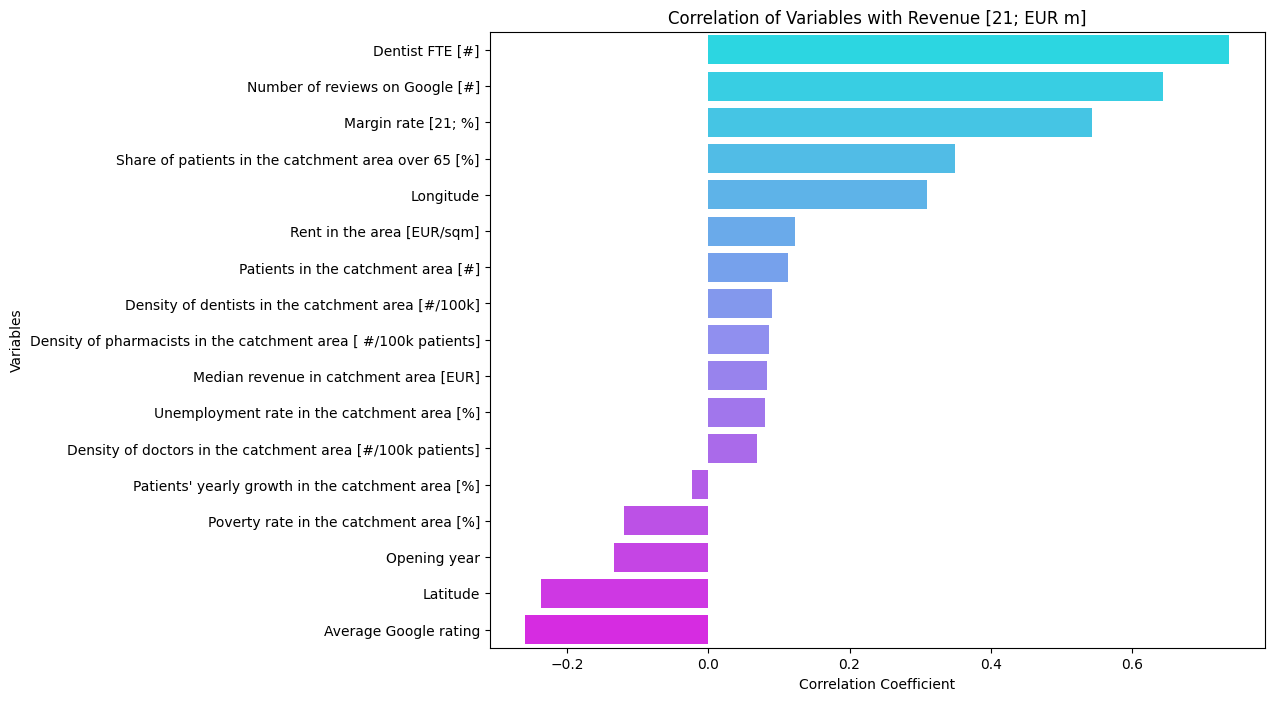

In [48]:
# Calculate correlations of all variables with the target
correlation_matrix = df.corr()
correlation_with_target = correlation_matrix[target].drop(target).sort_values(ascending=False)

# Display correlations with the target
plt.figure(figsize=(10, 8))
sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index, palette="cool", legend=False,hue=correlation_with_target.index)
plt.title(f"Correlation of Variables with {target}")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Variables")
plt.show()

The direct correlation analysis reveals that internal factors such as `Dentist FTE [#]`, `Number of reviews on Google [#]`, and `Margin rate [21; %]` exhibit the strongest positive relationships with `Revenue [21; EUR m]`. This suggests that operational metrics within the centers have a significant influence on performance.

However, this simple correlation analysis has limitations:

- It does not account for potential non-linear relationships or interactions between variables.
- Some variables, such as Average Google rating, show a negative correlation, which seems counterintuitive. This may indicate that higher ratings are associated with fewer reviews or specific local conditions, requiring further investigation.

To gain deeper insights and separate signal from noise, we will build small models. These models will allow us to ensure explainability by identifying the most impactful variables and understanding their contributions in driving center performance.

We will begin by trying simple models, such as Linear Regression, Ridge Regression, and Lasso Regression, to evaluate their performance and understand the linear relationships between features and revenue. This approach will provide a baseline for comparison and highlight the strengths and limitations of linear methods. Based on these results, we will then decide whether to explore more advanced, non-linear models to capture potential interactions and complex patterns in the data.

#### Simple Models

In [49]:
# Prepare data for modeling
X = df.drop(columns=[target])
y = df[target]

# Initialize models
linear_model = LinearRegression()
ridge_model = Ridge(alpha=1.0) 
lasso_model = Lasso(alpha=0.1)

# Train models on the entire dataset
linear_model.fit(X, y)
ridge_model.fit(X, y)
lasso_model.fit(X, y)

# Predictions on the training set
y_pred_linear = linear_model.predict(X)
y_pred_ridge = ridge_model.predict(X)
y_pred_lasso = lasso_model.predict(X)

# Performance metrics
performance = pd.DataFrame({
    "Model": ["Linear Regression", "Ridge Regression", "Lasso Regression"],
    "Mean Squared Error (MSE)": [
        mean_squared_error(y, y_pred_linear),
        mean_squared_error(y, y_pred_ridge),
        mean_squared_error(y, y_pred_lasso),
    ],
    "Mean Absolute Error (MAE)": [
        mean_absolute_error(y, y_pred_linear),
        mean_absolute_error(y, y_pred_ridge),
        mean_absolute_error(y, y_pred_lasso),
    ],
    "R-squared (R²)": [
        r2_score(y, y_pred_linear),
        r2_score(y, y_pred_ridge),
        r2_score(y, y_pred_lasso),
    ],
})

# Display performance metrics
performance

Model  Mean Squared Error (MSE)  Mean Absolute Error (MAE)  \
0  Linear Regression                  0.279084                   0.400619   
1   Ridge Regression                  0.279096                   0.400702   
2   Lasso Regression                  0.292815                   0.418032   

   R-squared (R²)  
0        0.821116  
1        0.821108  
2        0.812315

The evaluation of the simple models reveals strong performance in predicting revenue, with Linear Regression achieving the best R_square value of 0.82, indicating that it explains 82% of the variance in the target variable. Ridge Regression closely matches Linear Regression, with only marginally higher error values, showing that regularization does not significantly improve the model in this case. Lasso Regression, while slightly underperforming compared to the other two models (R_square = 0.81), demonstrates its utility in simplifying the model by focusing on the most impactful variables. Overall, these results establish a robust baseline, suggesting that linear methods are effective for this problem, but there is still room for improvement in capturing unexplained variance.

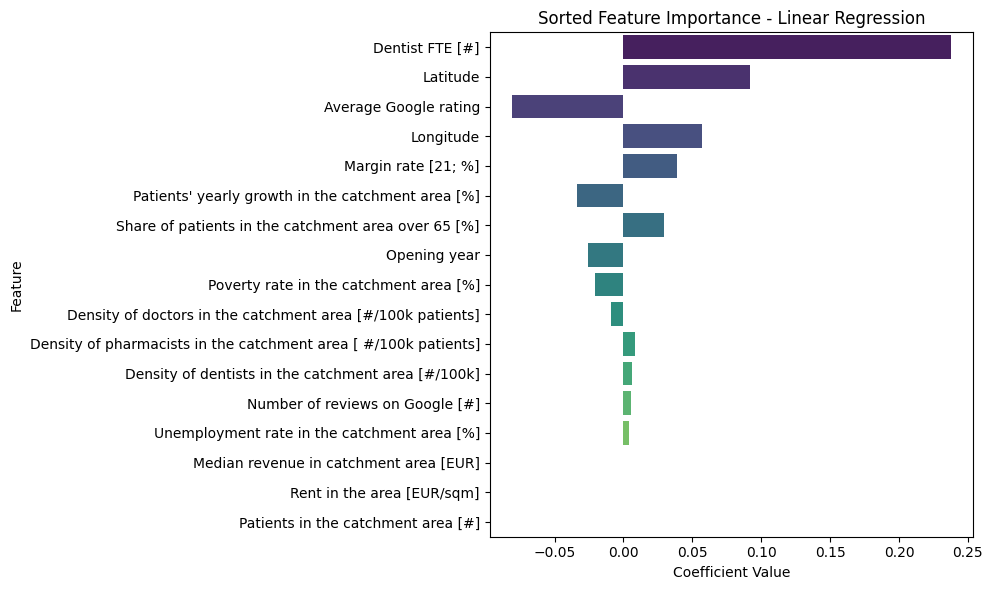

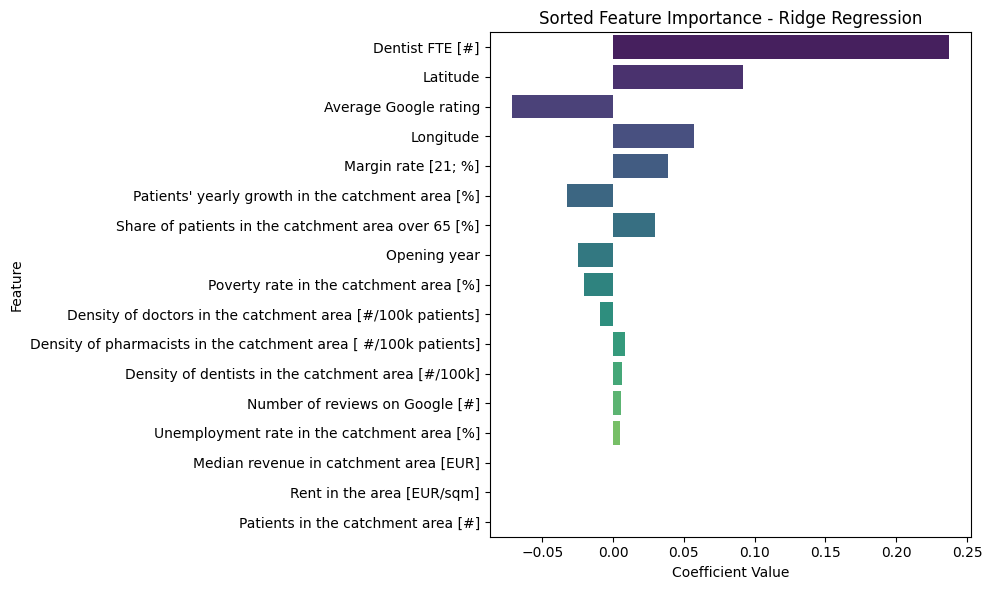

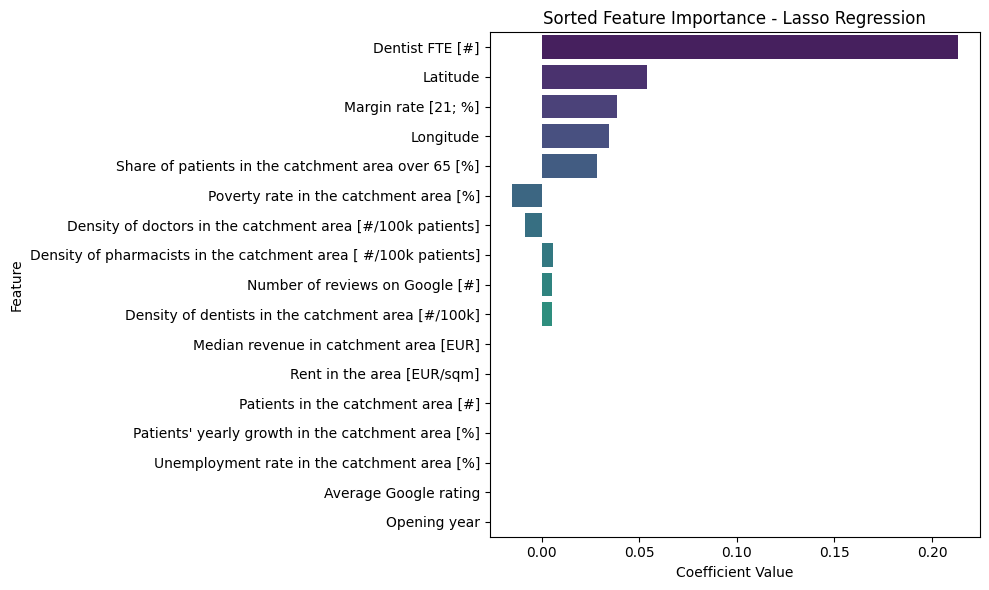

In [50]:
# Function to plot sorted feature importance
def plot_sorted_feature_importance(coefficients, model_name):
    importance_df = pd.DataFrame({
        "Feature": X.columns,
        "Coefficient": coefficients
    }).sort_values(by="Coefficient", key=np.abs, ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importance_df["Coefficient"], y=importance_df["Feature"], palette="viridis", legend=False, hue=importance_df["Feature"])
    plt.xlabel("Coefficient Value")
    plt.ylabel("Feature")
    plt.title(f"Sorted Feature Importance - {model_name}")
    plt.tight_layout()
    plt.show()

# Plot feature importance for each model
plot_sorted_feature_importance(linear_model.coef_, "Linear Regression")
plot_sorted_feature_importance(ridge_model.coef_, "Ridge Regression")
plot_sorted_feature_importance(lasso_model.coef_, "Lasso Regression")

The feature importance plots provide valuable insights into how each variable contributes to the target prediction. As expected, internal factors like `Dentist FTE [#]` and `Number of reviews on Google [#]` have significant positive impacts on revenue across all models. Ridge Regression and Lasso Regression reveal how regularization adjusts the importance of features: Ridge retains all features with reduced magnitudes, while Lasso highlights a subset of the most critical variables. Interestingly, some features, such as `Average Google rating`, show negative contributions, suggesting that their relationships with revenue might be more complex or involve interactions with other factors.

While linear models provide a solid foundation and clear interpretability, they are inherently limited in capturing non-linear relationships and feature interactions. The varying importance of features across Ridge and Lasso indicates potential complexities in the dataset that simple linear approaches may overlook. For instance, the negative contribution of `Average Google rating` suggests a more nuanced relationship that cannot be fully explained by linear methods.

To better capture the intricate relationships between features and revenue, we will now explore non-linear models. These methods, such as Random Forest and Gradient Boosting, are well-suited for structured data and can account for interactions and non-linear effects. Additionally, they provide robust feature importance metrics, offering deeper insights into the drivers of center performance. By comparing their results with linear models, we aim to achieve higher predictive accuracy and uncover additional insights into the dataset.

#### Non-Linear Models

Having established a robust baseline with simple linear models, we now turn to non-linear methods to capture potential interactions and complex relationships between features and the target variable.

##### Random Forest Regressor

Let's begin with a Random Forest model.

In [51]:
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the Random Forest model on the entire dataset
rf_model.fit(X, y)

# Predictions on the training set
y_pred_rf = rf_model.predict(X)

# Evaluate the Random Forest model
rf_performance = {
    "Model": "Random Forest",
    "Mean Squared Error (MSE)": mean_squared_error(y, y_pred_rf),
    "Mean Absolute Error (MAE)": mean_absolute_error(y, y_pred_rf),
    "R-squared (R²)": r2_score(y, y_pred_rf),
}

# Display Random Forest performance
pd.DataFrame([rf_performance])


Model  Mean Squared Error (MSE)  Mean Absolute Error (MAE)  \
0  Random Forest                   0.08422                   0.218299   

   R-squared (R²)  
0        0.946018

The Random Forest model demonstrates a significant improvement in performance over the linear models:

* The R_squared value of 0.947 indicates that the model explains 94.7% of the variance in revenue, compared to 82% for the best linear model.
* The Mean Squared Error (MSE) and Mean Absolute Error (MAE) have also decreased considerably, reflecting more accurate predictions.

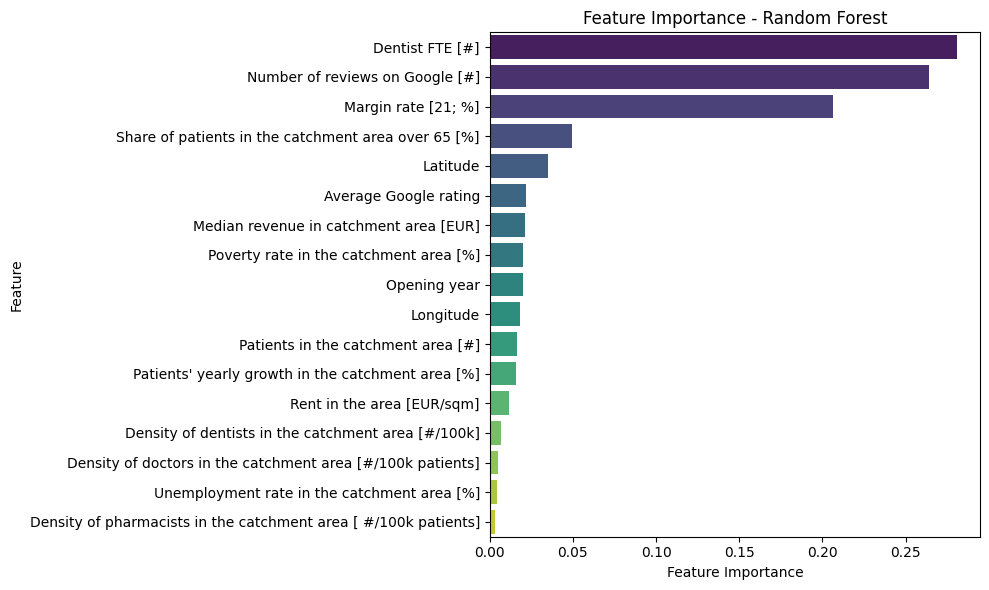

In [52]:
# Extract feature importance from the Random Forest model
rf_feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Plot feature importance for Random Forest
plt.figure(figsize=(10, 6))
sns.barplot(x=rf_feature_importance["Importance"], y=rf_feature_importance["Feature"], palette="viridis", legend=False, hue=rf_feature_importance["Feature"])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance - Random Forest")
plt.tight_layout()
plt.show()



Feature Importance Insights:

* The most important features are internal factors, with `Dentist FTE [#]`, `Number of reviews on Google [#]`, and `Margin rate [21; %]` contributing the most to revenue prediction.
* This model highlights a slight improvement in the importance of `Average Google rating` compared to the linear models. Although still not among the top predictors, it underscores the relevance of maintaining a balance between customer engagement (reviews) and quality of service (ratings).

##### Gradient Boosting Regressor

Building on the success of the Random Forest model, we will now explore Gradient Boosting techniques. These methods often deliver even better accuracy by sequentially minimizing errors, potentially uncovering further insights into the drivers of center performance.

In [53]:
# Initialize the Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the Gradient Boosting model on the entire dataset
gb_model.fit(X, y)

# Predictions on the training set
y_pred_gb = gb_model.predict(X)

# Evaluate the Gradient Boosting model
gb_performance = {
    "Model": "Gradient Boosting",
    "Mean Squared Error (MSE)": mean_squared_error(y, y_pred_gb),
    "Mean Absolute Error (MAE)": mean_absolute_error(y, y_pred_gb),
    "R-squared (R²)": r2_score(y, y_pred_gb),
}

# Convert Gradient Boosting performance into a DataFrame
pd.DataFrame([gb_performance])

Model  Mean Squared Error (MSE)  Mean Absolute Error (MAE)  \
0  Gradient Boosting                  0.001635                   0.034075   

   R-squared (R²)  
0        0.998952

The Gradient Boosting model demonstrates a significant leap in predictive performance compared to both Random Forest and linear models:

* The R_squared value of 0.999 shows that the model explains nearly all variance in revenue, achieving exceptional accuracy.
* The Mean Squared Error (MSE) and Mean Absolute Error (MAE) are drastically reduced, reflecting highly precise predictions.
* This substantial improvement underscores the ability of Gradient Boosting to capture complex non-linear relationships and interactions between features.

These results suggest that Gradient Boosting is particularly well-suited for this dataset and provides a robust framework for understanding center performance.

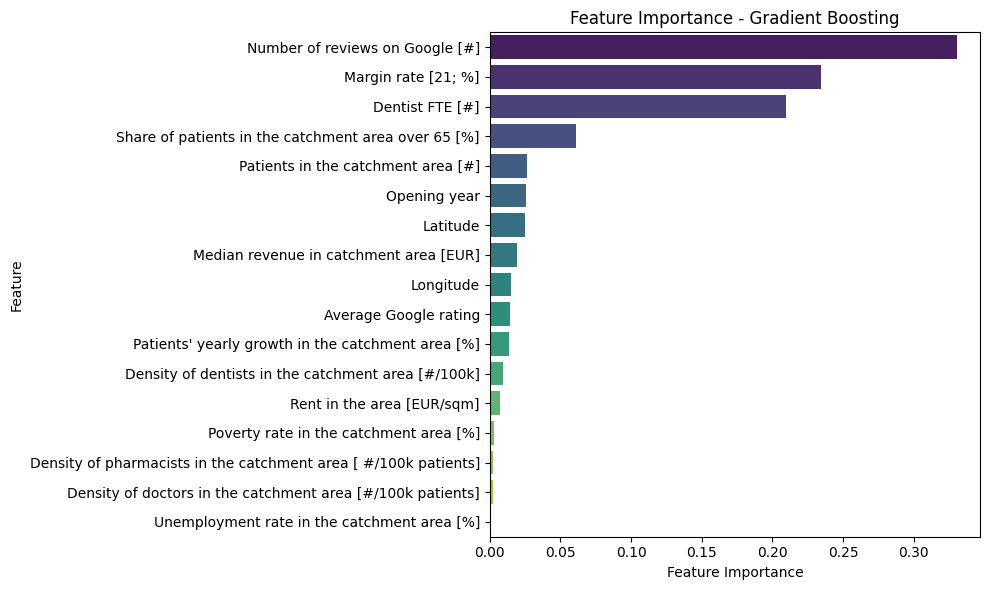

In [54]:
# Extract feature importance from the Gradient Boosting model
gb_feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": gb_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Plot feature importance for Gradient Boosting
plt.figure(figsize=(10, 6))
sns.barplot(x=gb_feature_importance["Importance"], y=gb_feature_importance["Feature"], palette="viridis" , legend=False, hue=gb_feature_importance["Feature"])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance - Gradient Boosting")
plt.tight_layout()
plt.show()

The feature importance analysis for Gradient Boosting highlights several key drivers of revenue:

* `Number of reviews on Google [#]` emerges as the most influential feature, accounting for 33% of the importance, reinforcing the role of customer engagement in driving performance.
* `Margin rate [21; %]` and `Dentist FTE [#]` remain critical, aligning with the findings from Random Forest.
* `Average Google rating`, while still less impactful than other internal factors, shows a slight increase in importance compared to linear models, suggesting its interplay with other variables.
* The inclusion of external factors like `Share of patients in the catchment area over 65 [%]` indicates that demographic and market conditions play a role, albeit secondary to internal operational factors. Overall, Gradient Boosting provides a nuanced understanding of the drivers of revenue, validating its suitability for this task.

#### Overall Conlusion

The analysis across all models provides a comprehensive understanding of the factors influencing center revenue. Here are the key insights:

1. Impact of Internal Factors:

Internal factors consistently emerge as the most critical drivers of revenue across all model.
 - `Dentist FTE [#]`, `Number of reviews on Google [#]`, and `Margin rate [21; %]` are the top contributors, indicating that staffing, customer engagement, and profitability are the primary levers for performance.
 - The importance of `Number of reviews on Google [#]`, particularly in Gradient Boosting, underscores the value of building strong customer relationships and maintaining a visible online presence.

2. Impact of External Factors:

External factors play a secondary role in influencing revenue.
 - Demographic variables like `Share of patients in the catchment area over 65 [%]` and `Patients in the catchment area [#]` are moderately important. These findings highlight the influence of market potential and age distribution but suggest that their impact is less direct than operational factors.
 - Economic variables such as `Poverty rate`, `Unemployment rate`, and `Median revenue` in the catchment area contribute minimally, indicating that broader economic conditions are less critical compared to localized operational metrics.

Key Takeaway:

The analysis clearly shows that `internal factors` have the most significant impact on center performance. These factors are directly within the clinic's control, making them the most actionable for driving improvements. External factors, while less influential, provide context for market potential and can guide strategic decisions such as location planning or service expansion.

## Question 3

Use an unsupervised learning technique to **cluster the dental centers**. How would you describe each cluster to the client in business terms?

In this part, we aim to segment the dental centers into meaningful groups (clusters) based on their internal and external features. To achieve this:

* We'll use the K-Means clustering algorithm to create clusters.
* We'll determine the optimal number of clusters (k) using the Elbow Method and Silhouette Scores.
* We'll use Principal Component Analysis (PCA) to reduce the dimensionality of the dataset for visualization and interpretability.
* Finally, we'll analyze the clusters to extract business insights and provide recommendations."

To start, let's evaluate the optimal number of clusters (k) by using the Elbow Method. This method helps us identify the point where adding more clusters no longer significantly reduces the within-cluster sum of squares (WCSS).

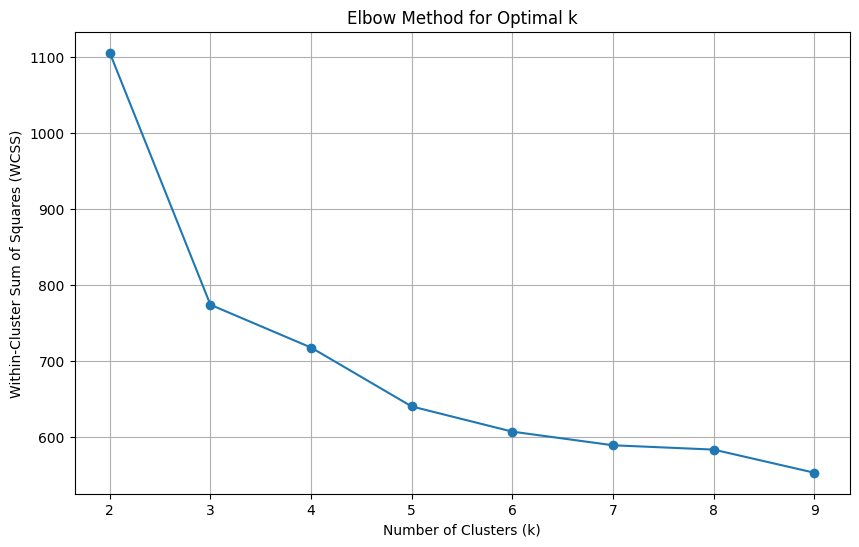

In [55]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

# Test different numbers of clusters
wcss = []
silhouette_scores = []
k_values = range(2, 10)  # Testing from 2 to 9 clusters

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=27)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)  # Sum of squared distances within clusters
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot the Elbow Method (WCSS)
plt.figure(figsize=(10, 6))
plt.plot(k_values, wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(k_values)
plt.grid(True)
plt.show()


The Elbow Method suggests that k=3 is a reasonable choice, as the reduction in WCSS starts to plateau at this point. However, we will confirm this using another metric: the Silhouette Score.

To further confirm the optimal k, we will compute the Silhouette Scores for each value of k. Higher silhouette scores indicate better-defined and more compact clusters.

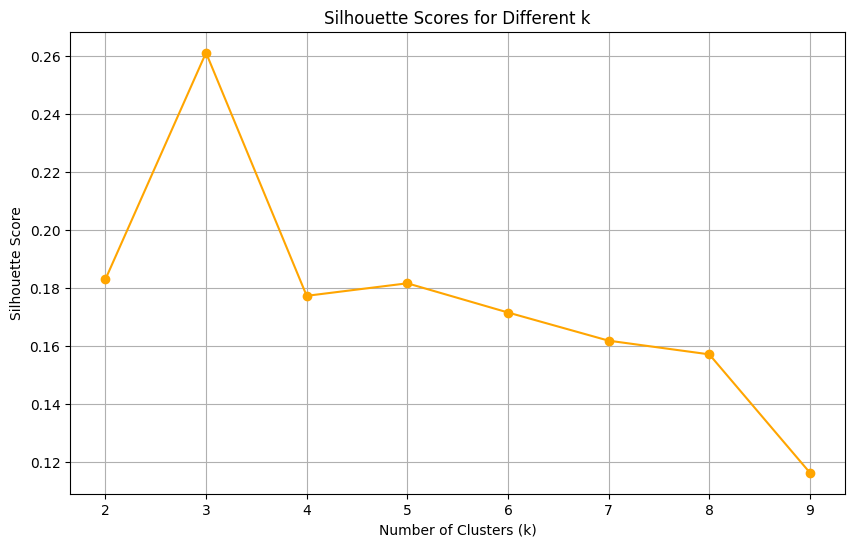

In [56]:
# Plot the Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Scores for Different k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)
plt.show()

The Silhouette Score confirms that k = 3 provides the best cluster separation. This aligns with the results from the Elbow Method. Therefore, we will proceed with k=3.

Now that we have identified k=3 as the optimal number of clusters, let's construct the K-Means model and assign each dental center to one of the three clusters.

In [57]:
# Use K-Means to cluster the data
kmeans = KMeans(n_clusters=3, random_state=10)  # Start with 3 clusters
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to the a new dataframe
df_clustered = df.copy()
df_clustered['Cluster'] = clusters

df_clustered['Cluster'].value_counts()


Cluster
0    36
2    18
1    17
Name: count, dtype: int64

The centers have been successfully clustered into 3 groups, with Cluster 0 being the largest. Now, to better understand the clusters, we will visualize them. Since there are many features, we will use PCA to reduce the dimensionality and project the data into 2D for better visualization.

Before visualizing, let's analyze the influence of each variable on the principal components.

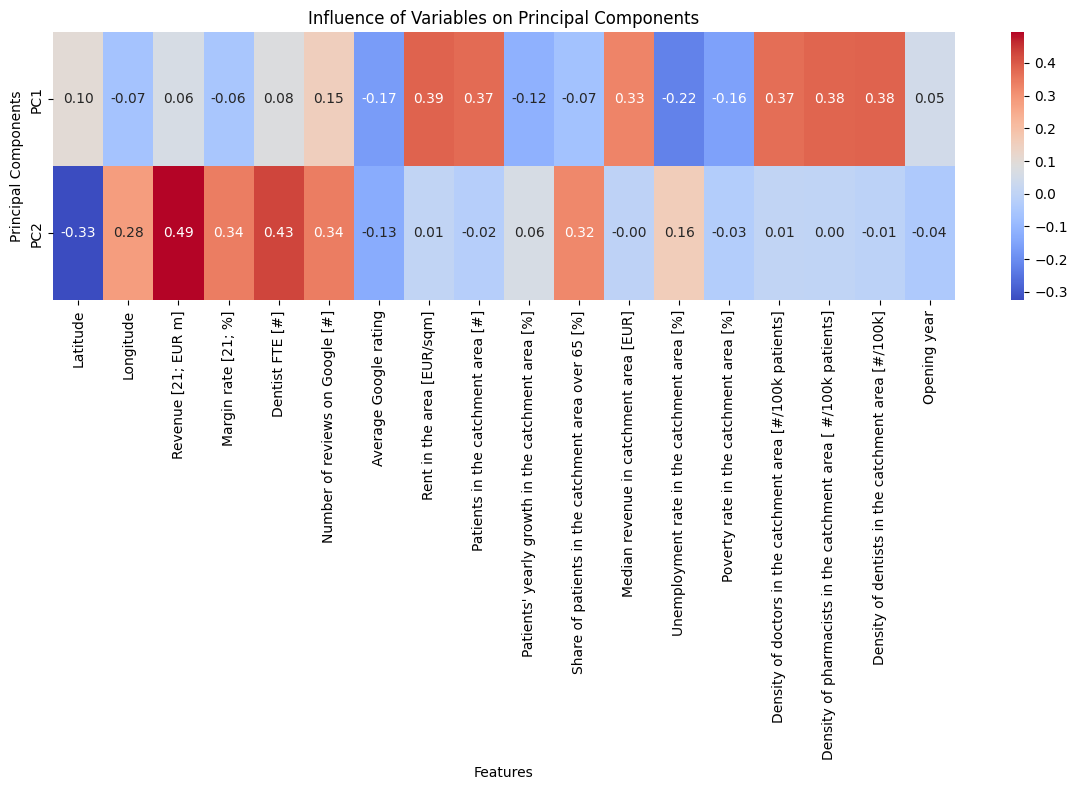

In [58]:
# Perform PCA for visualization (reduce to 2 components)
pca = PCA(n_components=2, random_state=53)
X_pca = pca.fit_transform(X_scaled)

# Analyze the influence of each variable on the principal components
pca_components = pd.DataFrame(
    pca.components_,
    columns=df.select_dtypes(include=[float, int]).columns,
    index=[f"PC{i+1}" for i in range(pca.n_components_)]
)

# Visualize the influence of variables on the first two principal components
plt.figure(figsize=(12, 8))
sns.heatmap(pca_components, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Influence of Variables on Principal Components")
plt.xlabel("Features")
plt.ylabel("Principal Components")
plt.tight_layout()
plt.show()



The PCA heatmap shows how each variable contributes to the principal components. Interestingly, we observe that the components are divided into two logical groups:

* The first principal component (PC1) focuses more on external factors like patient density and rent.
* The second principal component (PC2) focuses more on internal factors like revenue, Google reviews, and dentist staffing.

Using the PCA components, we can now visualize the clusters in a 2D scatter plot to check the separation and compactness of the clusters.

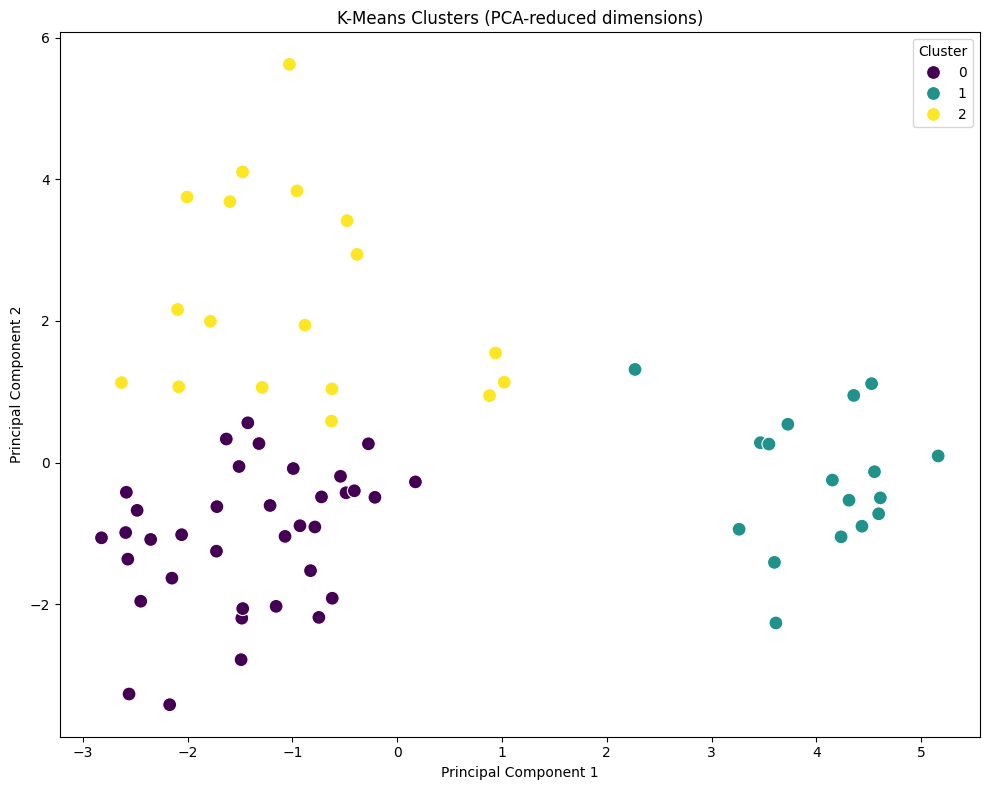

In [59]:
# Add PCA components to the dataframe for visualization
df_clustered['PCA1'] = X_pca[:, 0]
df_clustered['PCA2'] = X_pca[:, 1]

# Visualize the clusters in 2D
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df_clustered, palette='viridis', s=100)
plt.title('K-Means Clusters (PCA-reduced dimensions)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', loc='best')
plt.tight_layout()
plt.show()


The scatter plot shows that the clusters are well-separated in the PCA-reduced space. This indicates that the clustering is meaningful and aligns with the data structure.

To gain deeper business insights into the clusters, we will calculate the mean values of the features for each cluster. This will help us describe the unique characteristics of each group.

In [60]:
cluster_summary = df_clustered.groupby('Cluster').mean().drop(columns=['PCA1', 'PCA2'])

cluster_summary

Latitude  Longitude  Revenue [21; EUR m]  Margin rate [21; %]  \
Cluster                                                                   
0        47.924617   2.609731             1.358502            12.901515   
1        48.858972   2.347932             2.341176            12.529412   
2        44.595964   5.299251             3.361195            19.020202   

         Dentist FTE [#]  Number of reviews on Google [#]  \
Cluster                                                     
0               5.069865                        78.127778   
1               6.764706                       183.294118   
2               8.632155                       193.433333   

         Average Google rating  Rent in the area [EUR/sqm]  \
Cluster                                                      
0                     4.254754                 3339.500000   
1                     3.878503                10885.823529   
2                     4.159762                 4192.055556   

         Patients in the catchment area [#]  \
Cluster                                       
0                              48013.791137   
1                             178821.971007   
2                              48383.600105   

         Patients' yearly growth in the catchment area [%]  \
Cluster                                                      
0                                                 0.215556   
1                                                -0.415882   
2                                                 0.548333   

         Share of patients in the catchment area over 65 [%]  \
Cluster                                                        
0                                                14.436781     
1                                                15.462680     
2                                                23.042139     

         Median revenue in catchment area [EUR]  \
Cluster                                           
0                                  20699.107190   
1                                  28829.160072   
2                                  22096.778420   

         Unemployment rate in the catchment area [%]  \
Cluster                                                
0                                           8.163889   
1                                           6.411765   
2                                           8.504167   

         Poverty rate in the catchment area [%]  \
Cluster                                           
0                                     18.967887   
1                                     13.379118   
2                                     15.698496   

         Density of doctors in the catchment area [#/100k patients]  \
Cluster                                                               
0                                               152.338889            
1                                               242.647059            
2                                               161.166667            

         Density of pharmacists in the catchment area [ #/100k patients]  \
Cluster                                                                    
0                                                61.444444                 
1                                               137.764706                 
2                                                67.777778                 

         Density of dentists in the catchment area [#/100k]  Opening year  
Cluster                                                                    
0                                               110.250000    2019.138889  
1                                               185.352941    2019.176471  
2                                               118.611111    2018.888889

The cluster summary provides a clear picture of the distinguishing characteristics of each group:

*Cluster 0: Moderate Performers*:
 - Centers with moderate revenue and profitability.
- Moderate staffing levels and reviews.
- Located in regions with lower patient density and higher elderly population.

Recommendation: Focus on operational optimizations and building stronger customer engagement to boost Google ratings and profitability.

*Cluster 1: High-Demand Urban Centers*:

* High revenue centers operating in high-cost, high-density urban areas.
* Relatively lower Google ratings despite having many reviews.

Recommendation: Improve customer satisfaction (like patient experience, Google ratings) and optimize costs in these high-rent areas.

*Cluster 2: Top Performers*:

* Centers with the highest revenue and profitability, well-staffed with good Google ratings.
* Operate in areas with affluent demographics but moderate patient density.

Recommendation: Maintain operational excellence while exploring premium services or expanding in similar regions.


**Conclusion**:

This analysis highlights actionable insights for each cluster, enabling the dental clinic chain to tailor strategies to the unique needs of their centers. By focusing on customer satisfaction, operational efficiency, and leveraging demographic strengths, the chain can drive overall performance improvement.

## Question 4

Let's **enrich our dataset** with additional data on competition. Download the following file providing an overview of all medical institutions in France with their geo coordinates and convert it to a clean dataframe: https://www.data.gouv.fr/fr/datasets/r/98f3161f-79ff-4f16-8f6a-6d571a80fea2. 

Perform the necessary **filters to separate dental centers** from the other institutions.

**Reproject the geo coordinates** to the ESPG:4326 coordinate reference system (same as the coordinates in the dental center dataset).

*Hint: to perform operations on coordinates, the libraries shapely, geopandas and pyproj might be helpful*

-----------------------------------------------------------------------

First, since the data is quite messy, I conducted an online search to understand the source and structure of this dataset. This helped me determine how to handle it effectively. The source page with relevant information can be found here: https://www.data.gouv.fr/fr/datasets/finess-extraction-du-fichier-des-etablissements/.

Additionally, there is a PDF in the project folder that describes the different elements of the dataset, which provides further clarity.

Let's begin by loading the dataset and inspecting its structure to understand its composition and identify potential issues.

In [61]:
competition_data = pd.read_csv('competition_data.csv', sep=';')

C:\Users\moham\AppData\Local\Temp\ipykernel_17776\2992612203.py:1: DtypeWarning: Columns (1,2,3,6,8,9,10,11,13,14,15,19,21,23,25,27,28,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  competition_data = pd.read_csv('competition_data.csv', sep=';')


In [62]:
competition_data.shape

(201362, 4)

It seems like the data isn't well parsed. Let's examine the first few rows to get more insights.

In [63]:
competition_data

finess  \
structureet     10000024  10780054 CH DE FLEYRIAT              CENTRE HOSPITALIER DE BOURG-EN-BRESSE FLEYRIAT     NaN        NaN 900.0  RTE DE PARIS         NaN NaN    451.0 1   AIN 01440 VIRIAT        4.744546e+08 4.744541e+08 355.0 Centre Hospitalier (C.H.)            1102.0 Centres Hospitaliers 2.601000e+13 8610Z 3.0  ARS établissements Publics de santé dotation gl... 1.0 Etablissement public de santé  1979-02-13   
                10000032  10780062 CH BUGEY SUD                CENTRE HOSPITALIER BUGEY SUD                       NaN        NaN 700.0  AV  DE NARVIK        NaN BP 139 34.0  1   AIN 01300 BELLEY        4.794260e+08 4.794260e+08 355.0 Centre Hospitalier (C.H.)            1102.0 Centres Hospitaliers 2.601000e+13 8610Z 3.0  ARS établissements Publics de santé dotation gl... 1.0 Etablissement public de santé  1901-01-01   
                10000065  10780096 CH DE TREVOUX - MONTPENSIER CENTRE HOSPITALIER DE TREVOUX - MONTPENSIER        NaN        NaN 14.0   R   DE L'HOPITAL     NaN BP 615 427.0 1   AIN 01606 TREVOUX CEDEX 4.741050e+08 4.741050e+08 355.0 Centre Hospitalier (C.H.)            1102.0 Centres Hospitaliers 2.601003e+13 8610Z 3.0  ARS établissements Publics de santé dotation gl... 1.0 Etablissement public de santé  1901-01-01   
                10000081  10780112 CH DU PAYS DE GEX           CENTRE HOSPITALIER DU PAYS DE GEX                  NaN        NaN 160.0  R   MARC PANISSOD    NaN BP 437 173.0 1   AIN 01174 GEX CEDEX     4.504038e+08 4.504038e+08 106.0 Centre hospitalier, ex Hôpital local 1106.0 Hôpitaux Locaux      2.601001e+13 8610Z 3.0  ARS établissements Publics de santé dotation gl... 1.0 Etablissement public de santé  1901-01-01   
                10000099  10780120 CH DE MEXIMIEUX             CENTRE HOSPITALIER DE MEXIMIEUX                    NaN        NaN 13.0   AV  DU DOCTEUR BOYER NaN NaN    244.0 1   AIN 01800 MEXIMIEUX     4.746102e+08 4.743472e+08 106.0 Centre hospitalier, ex Hôpital local 1106.0 Hôpitaux Locaux      2.601001e+13 8610Z 3.0  ARS établissements Publics de santé dotation gl... 1.0 Etablissement public de santé  1945-01-01   
...                                                                                                                                                                                                                                                                                                                                                                                                                             ...   
geolocalisation 980502983 513388.0 8595803.0                   1,ATLASANTE,85,BAN_06-11-2024,UTM_S38_MAYOTTE      2024-11-04 NaN NaN    NaN NaN              NaN NaN    NaN   NaN NaN NaN                 NaN          NaN          NaN   NaN                                  NaN    NaN                  NaN          NaN   NaN  NaN                                                NaN NaN                                   NaN   
                980503007 516287.7 8569927.3                   4,ATLASANTE,.,ADMIN-EXPRESS-2023,UTM_S38_MAYOTTE   2024-11-04 NaN NaN    NaN NaN              NaN NaN    NaN   NaN NaN NaN                 NaN          NaN          NaN   NaN                                  NaN    NaN                  NaN          NaN   NaN  NaN                                                NaN NaN                                   NaN   
                980503064 524492.6 8588839.5                   2,ATLASANTE,83,BAN_06-11-2024,UTM_S38_MAYOTTE      2024-11-04 NaN NaN    NaN NaN              NaN NaN    NaN   NaN NaN NaN                 NaN          NaN          NaN   NaN                                  NaN    NaN                  NaN          NaN   NaN  NaN                                                NaN NaN                                   NaN   
                980600027 589277.4 8531397.3                   4,ATLASANTE,.,MAPS 06-11-2024,UTM_S1_WALLIS_FUTUNA 2024-11-04 NaN NaN    NaN NaN              NaN NaN    NaN   NaN NaN N

From the initial inspection, we can conclude that all the relevant information is embedded in the index of each row rather than in separate columns. Let's handle this by resetting the index.

In [64]:
# Reset the index to bring it as a column
competition_data.reset_index(inplace=True)
competition_data.head()

level_0   level_1   level_2                      level_3  \
0  structureet  10000024  10780054               CH DE FLEYRIAT   
1  structureet  10000032  10780062                 CH BUGEY SUD   
2  structureet  10000065  10780096  CH DE TREVOUX - MONTPENSIER   
3  structureet  10000081  10780112            CH DU PAYS DE GEX   
4  structureet  10000099  10780120              CH DE MEXIMIEUX   

                                          level_4 level_5 level_6  level_7  \
0  CENTRE HOSPITALIER DE BOURG-EN-BRESSE FLEYRIAT     NaN     NaN    900.0   
1                    CENTRE HOSPITALIER BUGEY SUD     NaN     NaN    700.0   
2     CENTRE HOSPITALIER DE TREVOUX - MONTPENSIER     NaN     NaN     14.0   
3               CENTRE HOSPITALIER DU PAYS DE GEX     NaN     NaN    160.0   
4                 CENTRE HOSPITALIER DE MEXIMIEUX     NaN     NaN     13.0   

  level_8           level_9  ...      level_22 level_23  level_24  \
0     RTE          DE PARIS  ...  2.601000e+13    8610Z       3.0   
1      AV         DE NARVIK  ...  2.601000e+13    8610Z       3.0   
2       R      DE L'HOPITAL  ...  2.601003e+13    8610Z       3.0   
3       R     MARC PANISSOD  ...  2.601001e+13    8610Z       3.0   
4      AV  DU DOCTEUR BOYER  ...  2.601001e+13    8610Z       3.0   

                                            level_25 level_26  \
0  ARS établissements Publics de santé dotation g...      1.0   
1  ARS établissements Publics de santé dotation g...      1.0   
2  ARS établissements Publics de santé dotation g...      1.0   
3  ARS établissements Publics de santé dotation g...      1.0   
4  ARS établissements Publics de santé dotation g...      1.0   

                        level_27      finess      etalab          77  \
0  Etablissement public de santé  1979-02-13  1979-02-13  2020-02-04   
1  Etablissement public de santé  1901-01-01  1901-01-01  2021-07-07   
2  Etablissement public de santé  1901-01-01  1901-01-01  2018-01-12   
3  Etablissement public de santé  1901-01-01  1901-01-01  2020-02-04   
4  Etablissement public de santé  1945-01-01  1945-01-01  2020-06-30   

  2024-11-08  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN  

[5 rows x 32 columns]

Further inspection reveals that the dataset is divided into two sections:

* The first half contains primary information.
* The second half contains complementary information for each entry in the first half.

Let's split the dataset into these two halves and combine them for a more structured format."

In [65]:
# Split the dataset into two halves
half_index = len(competition_data) // 2
first_half = competition_data.iloc[:half_index].reset_index(drop=True)
second_half = competition_data.iloc[half_index:].reset_index(drop=True)
second_half.columns = [f'{col} (2)' for col in second_half.columns]

# Concatenate the two halves column-wise
transformed_data = pd.concat([first_half, second_half], axis=1)

# Check the resulting structure
i=0
for value in transformed_data.iloc[1,:] :
    if i < 7 or i > 31 and i < 36:
        print(transformed_data.columns[i] + ' : ', end='')
        print(value)
    i+=1



level_0 : structureet
level_1 : 10000032
level_2 : 10780062
level_3 : CH BUGEY SUD
level_4 : CENTRE HOSPITALIER BUGEY SUD
level_5 : nan
level_6 : nan
level_0 (2) : geolocalisation
level_1 (2) : 10000032
level_2 (2) : 908313.3
level_3 (2) : 6520061.2


Now, we have a more readable dataset where each column represents a relevant piece of information. In particular:

* The columns level_2 (2) and level_3 (2) represent the geographical coordinates.
* The column level_3 contains the name of the center.

Let's extract only the columns we need for further analysis.

In [66]:
columns_with_coordinates = transformed_data[['level_3', 'level_4', 'level_5', 'level_2 (2)', 'level_3 (2)']]
columns_with_coordinates.columns = ['Raison sociale rs', 'Raison sociale longue rslongue', 'Complément de raison sociale', 'Coordonnées X', 'Coordonnées Y']
columns_with_coordinates

Raison sociale rs  \
0                    CH DE FLEYRIAT   
1                      CH BUGEY SUD   
2       CH DE TREVOUX - MONTPENSIER   
3                 CH DU PAYS DE GEX   
4                   CH DE MEXIMIEUX   
...                             ...   
100676            SSIAD - PA - NORD   
100677                     CPTS SUD   
100678            PHARMACIE VANILLE   
100679               HOPITAL DE SIA   
100680        HOPITAL DE KALEVELEVE   

                         Raison sociale longue rslongue  \
0        CENTRE HOSPITALIER DE BOURG-EN-BRESSE FLEYRIAT   
1                          CENTRE HOSPITALIER BUGEY SUD   
2           CENTRE HOSPITALIER DE TREVOUX - MONTPENSIER   
3                     CENTRE HOSPITALIER DU PAYS DE GEX   
4                       CENTRE HOSPITALIER DE MEXIMIEUX   
...                                                 ...   
100676                   SSIAD - PERSONNES ÂGÉES - NORD   
100677  COMMUNAUTE PROFESSIONNELLE TERRITORIAL DE SANTE   
100678                                PHARMACIE VANILLE   
100679                                              NaN   
100680                                              NaN   

       Complément de raison sociale Coordonnées X Coordonnées Y  
0                               NaN      870199.9     6571579.2  
1                               NaN      908313.3     6520061.2  
2                               NaN      837272.3     6539470.4  
3                               NaN      935201.9     6584824.4  
4                               NaN      870118.2     6536469.4  
...                             ...           ...           ...  
100676                          NaN      513388.0     8595803.0  
100677                          NaN      516287.7     8569927.3  
100678                          NaN      524492.6     8588839.5  
100679                          NaN      589277.4     8531397.3  
100680                          NaN      375068.1     8419154.0  

[100681 rows x 5 columns]

The dataset includes all types of medical centers, not just dental centers. Let's filter the data to include only rows where the word 'dentaire' appears in one of the first three columns (`Raison sociale rs`, `Raison sociale longue rslongue`, or `Complément de raison sociale`).

In [67]:
list_of_dental = []
# Parse each row to check if 'dentaire' exists in the relevant columns
for index, row in columns_with_coordinates.iterrows():
    if any('dentaire' in str(value).lower() for value in row[['Raison sociale rs', 'Raison sociale longue rslongue', 'Complément de raison sociale']]):
        # If 'dentaire' is found, add the relevant values to the new dataframe
        list_of_dental.append({
            'Raison sociale': row['Raison sociale rs'],
            'Coordonnées X': row['Coordonnées X'],
            'Coordonnées Y': row['Coordonnées Y']
        })


In [68]:
# Create a new dataframe with dental-related rows with columns

dental_centers = pd.DataFrame(list_of_dental)
dental_centers

Raison sociale  Coordonnées X Coordonnées Y
0            CENTRE DE SANTE FERNEY-VOLTAIRE       939643.2     6577821.3
1        CENTRE DE SANTE DENTAIRE CLEMENCEAU       904204.7     6576314.4
2         CENTRE DE SANTE DENTAIRE D'OYONNAX       904155.7     6576568.8
3     CENTRE DE SANTE DE SAINT GENIS POUILLY       933186.6     6577271.7
4     CENTRE DE SANTE MEDICO-DENT VALSERHONE       918339.4     6560346.3
...                                      ...            ...           ...
1355       CENTRE DE SANTE DENTAIRE HYGIDENT       704516.1     1616713.1
1356  CENTRE DE SANTE DENTAIRE MADININA SMIL       716627.4     1617128.7
1357           CENTRE DE SANTE DENTAIRE OGSO       358560.6      540592.0
1358                CENTRE DE SANTE DENTAIRE       339932.5     7689165.4
1359     CENTRE DE SANTÉ DENTAIRE DENTALURG       330002.9     7647776.4

[1360 rows x 3 columns]

And finally, this is our resulting dataset containing all the dental centers, with their names and geographical coordinates. This data is now ready for further analysis.

In [69]:
# Convert coordinates to numeric
dental_centers['Coordonnées X'] = pd.to_numeric(dental_centers['Coordonnées X'], errors='coerce')
dental_centers['Coordonnées Y'] = pd.to_numeric(dental_centers['Coordonnées Y'], errors='coerce')

Let's now convert all the coordinates to the EPSG:4326 form

In [70]:
# Create a GeoDataFrame from the dental_centers dataframe
geometry = [Point(xy) for xy in zip(dental_centers['Coordonnées X'], dental_centers['Coordonnées Y'])]
dental_gdf = gpd.GeoDataFrame(dental_centers, geometry=geometry)

# Set the source CRS to EPSG:2154 (Lambert-93)
dental_gdf.set_crs("EPSG:2154", inplace=True)

# Reproject to EPSG:4326 (WGS84)
dental_gdf = dental_gdf.to_crs("EPSG:4326")

# Extract Latitude and Longitude
dental_gdf['Latitude'] = dental_gdf.geometry.y
dental_gdf['Longitude'] = dental_gdf.geometry.x

# Drop the geometry column if not needed
dental_gdf = dental_gdf.drop(columns='geometry')

dental_gdf


Raison sociale  Coordonnées X  Coordonnées Y  \
0            CENTRE DE SANTE FERNEY-VOLTAIRE       939643.2      6577821.3   
1        CENTRE DE SANTE DENTAIRE CLEMENCEAU       904204.7      6576314.4   
2         CENTRE DE SANTE DENTAIRE D'OYONNAX       904155.7      6576568.8   
3     CENTRE DE SANTE DE SAINT GENIS POUILLY       933186.6      6577271.7   
4     CENTRE DE SANTE MEDICO-DENT VALSERHONE       918339.4      6560346.3   
...                                      ...            ...            ...   
1355       CENTRE DE SANTE DENTAIRE HYGIDENT       704516.1      1616713.1   
1356  CENTRE DE SANTE DENTAIRE MADININA SMIL       716627.4      1617128.7   
1357           CENTRE DE SANTE DENTAIRE OGSO       358560.6       540592.0   
1358                CENTRE DE SANTE DENTAIRE       339932.5      7689165.4   
1359     CENTRE DE SANTÉ DENTAIRE DENTALURG       330002.9      7647776.4   

       Latitude  Longitude  
0     46.257763   6.111825  
1     46.255845   5.651367  
2     46.258150   5.650842  
3     46.255077   6.027794  
4     46.107727   5.827317  
...         ...        ...  
1355   4.985079   3.032304  
1356   4.987977   3.118942  
1357  -2.433992   0.775178  
1358  56.134312  -2.714782  
1359  55.762133  -2.823453  

[1360 rows x 5 columns]

We see that there are some anomalies (like -2.433992	0.775178). let's handle them by droping all coordinates outside France area

In [71]:
# Define France's approximate geographic boundaries (EPSG:4326)
FRANCE_BOUNDS = {
    "lat_min": 41.0,
    "lat_max": 51.2,
    "lon_min": -5.2,
    "lon_max": 9.6
}

# Filter out anomalies
dental_gdf = dental_gdf[
    (dental_gdf['Latitude'] >= FRANCE_BOUNDS["lat_min"]) &
    (dental_gdf['Latitude'] <= FRANCE_BOUNDS["lat_max"]) &
    (dental_gdf['Longitude'] >= FRANCE_BOUNDS["lon_min"]) &
    (dental_gdf['Longitude'] <= FRANCE_BOUNDS["lon_max"])
]

dental_gdf


Raison sociale  Coordonnées X  Coordonnées Y  \
0            CENTRE DE SANTE FERNEY-VOLTAIRE       939643.2      6577821.3   
1        CENTRE DE SANTE DENTAIRE CLEMENCEAU       904204.7      6576314.4   
2         CENTRE DE SANTE DENTAIRE D'OYONNAX       904155.7      6576568.8   
3     CENTRE DE SANTE DE SAINT GENIS POUILLY       933186.6      6577271.7   
4     CENTRE DE SANTE MEDICO-DENT VALSERHONE       918339.4      6560346.3   
...                                      ...            ...            ...   
1348    CDS CENTRE MEDICO DENTAIRE LA FRETTE       639966.1      6875985.0   
1349          CDS DENTAIRE D AUVERS SUR OISE       639666.0      6885963.2   
1350          CDS CENTRE DENTAIRE CERGY GARE       627855.6      6883750.5   
1351            CDS DENTAIRE FUTURSMILE OSNY       632655.1      6886864.4   
1352       CDS CENTRE DENTAIRE SAINT GRATIEN       647553.9      6874141.9   

       Latitude  Longitude  
0     46.257763   6.111825  
1     46.255845   5.651367  
2     46.258150   5.650842  
3     46.255077   6.027794  
4     46.107727   5.827317  
...         ...        ...  
1348  48.980995   2.179834  
1349  49.070684   2.174309  
1350  49.049571   2.013073  
1351  49.078089   2.078227  
1352  48.965086   2.283719  

[1353 rows x 5 columns]

In [72]:
# Create a map centered around France

dental_map = folium.Map(location=[47.05123, 2.726777], zoom_start=6)
marker_cluster = MarkerCluster().add_to(dental_map)

# Add markers for each dental center
for idx, row in dental_gdf.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"Raison sociale: {row['Raison sociale']}",
        tooltip=f"Center ID: {idx}"
    ).add_to(marker_cluster)

# Save the map as an HTML file
dental_map.save('all_comptetition_dental_centers.html')

# Display the map
dental_map

You can check the HTML file of this map in the project folder

In [73]:
# save the new data

dental_gdf = dental_gdf.drop(columns=['Coordonnées X', 'Coordonnées Y'])
dental_gdf.to_excel('comptetition_dental_centers.xlsx')

In [74]:
dental_gdf

Raison sociale   Latitude  Longitude
0            CENTRE DE SANTE FERNEY-VOLTAIRE  46.257763   6.111825
1        CENTRE DE SANTE DENTAIRE CLEMENCEAU  46.255845   5.651367
2         CENTRE DE SANTE DENTAIRE D'OYONNAX  46.258150   5.650842
3     CENTRE DE SANTE DE SAINT GENIS POUILLY  46.255077   6.027794
4     CENTRE DE SANTE MEDICO-DENT VALSERHONE  46.107727   5.827317
...                                      ...        ...        ...
1348    CDS CENTRE MEDICO DENTAIRE LA FRETTE  48.980995   2.179834
1349          CDS DENTAIRE D AUVERS SUR OISE  49.070684   2.174309
1350          CDS CENTRE DENTAIRE CERGY GARE  49.049571   2.013073
1351            CDS DENTAIRE FUTURSMILE OSNY  49.078089   2.078227
1352       CDS CENTRE DENTAIRE SAINT GRATIEN  48.965086   2.283719

[1353 rows x 3 columns]

## Question 5

Let's **assess competitive intensity** around the dental centers. First **draw a circle with a 500 meter radius** around each of the 71 dental center (under the form of a POLYGON). We will refer to these shapes as center catchment areas.
Then, **compute the number of competitors**, i.e. dental centers from the dataset you built in question 4 within each catchment area. Name this variable competitive intensity.

*Hint: to perform operations on coordinates, the libraries shapely, geopandas and pyproj might be helpful*

In [75]:
competitor_centers = pd.read_excel('comptetition_dental_centers.xlsx')
client_centers = pd.read_excel('cleaned_20231124_dental_center_data.xlsx')

# Create GeoDataFrames for both datasets
client_gdf = gpd.GeoDataFrame(
    client_centers,
    geometry=[Point(xy) for xy in zip(client_centers['Longitude'], client_centers['Latitude'])],
    crs="EPSG:4326"
)

competitor_gdf = gpd.GeoDataFrame(
    competitor_centers,
    geometry=[Point(xy) for xy in zip(competitor_centers['Longitude'], competitor_centers['Latitude'])],
    crs="EPSG:4326"
)

# Reproject both GeoDataFrames to a projected CRS for accurate distance measurement
client_gdf = client_gdf.to_crs("EPSG:3857")
competitor_gdf = competitor_gdf.to_crs("EPSG:3857")

# Create 500-meter buffers (catchment areas) around each client center
client_gdf['catchment_area'] = client_gdf.geometry.buffer(500)

# Add a column to store competitors' details
client_gdf['competitor details'] = None

# Function to count competitors and save their details, excluding self within 30 meters
def count_and_store_competitors(center, buffer, competitors):
    # Competitors within the buffer
    within_competitors = competitors[competitors.geometry.within(buffer)]
    # Exclude those within 30 meters of the center itself
    far_competitors = within_competitors[within_competitors.geometry.distance(center) > 30]
    # Return count and list of competitor details
    return len(far_competitors), far_competitors['Raison sociale'].tolist()


# Process each client center
for idx, row in client_gdf.iterrows():
    buffer = row['geometry'].buffer(500)  # Create the 500-meter buffer
    count, details = count_and_store_competitors(row['geometry'], buffer, competitor_gdf)
    client_gdf.at[idx, 'competitive intensity'] = count
    client_gdf.at[idx, 'competitor details'] = details

# Convert competitor_details to a more readable format (if needed)
client_gdf['competitor details'] = client_gdf['competitor details'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

# Save the results with competitor details
client_gdf.to_excel('final_data_client_centers_with_competitive_intensity.xlsx', index=False)


client_gdf

ID   Latitude  Longitude  Revenue [21; EUR m]  Margin rate [21; %]  \
0    1  48.804336   2.420931                  2.4                 18.0   
1    2  49.895083   2.298487                  2.6                 21.0   
2    3  43.578549   7.119384                  3.3                 21.0   
3    4  43.655764   1.370467                  2.2                  9.0   
4    5  44.879637  -0.570372                  2.9                 21.0   
..  ..        ...        ...                  ...                  ...   
66  67  50.725329   3.156516                  3.0                 20.0   
67  68  47.390305   0.692110                  1.3                 14.0   
68  69  50.360704   3.525183                  0.0                 20.0   
69  70  50.616725   3.133466                  1.5                 19.0   
70  71  45.770666   4.873808                  1.5                 16.0   

    Dentist FTE [#]  Number of reviews on Google [#]  Average Google rating  \
0               7.0                            190.0               3.552632   
1               9.0                            153.0               4.039216   
2              10.0                            163.0               4.288344   
3              10.0                            145.0               4.158621   
4               8.0                             63.0               4.650794   
..              ...                              ...                    ...   
66              7.0                            156.0               3.852564   
67              5.0                            114.0               4.140351   
68              2.0                              8.0               4.500000   
69              4.0                             46.0               4.891304   
70              6.0                             20.0               3.600000   

    Rent in the area [EUR/sqm]  Patients in the catchment area [#]  ...  \
0                         5731                        58874.899010  ...   
1                         2708                        39687.660222  ...   
2                         4751                        25370.677794  ...   
3                         3205                         6945.136108  ...   
4                         3707                         6992.074760  ...   
..                         ...                                 ...  ...   
66                        1924                        55181.794469  ...   
67                        3307                        49207.863713  ...   
68                        1871                        22191.019956  ...   
69                        3484                        24675.533216  ...   
70                        4711                       122700.517214  ...   

    Unemployment rate in the catchment area [%]  \
0                                           7.8   
1                                           9.6   
2                                          12.5   
3                                           8.1   
4                                           7.4   
..                                          ...   
66                                         10.1   
67                                          7.0   
68                                         10.1   
69                                         10.1   
70                                          7.2   

    Poverty rate in the catchment area [%]  \
0                                13.615055   
1                                20.113324   
2                                15.142544   
3                                 8.124205   
4                                30.930467   
..                                     ...   
66                               26.477449   
67                               19.619967   
68                               19.539536   
69                               23.194949   
70                               14.731955   

    Density of doctors in the catchment area [#/100k patients]  \
0                                

Since the competitors data may include also coordonates of the client's centers, we will consider only competitors 30m away in order to avoid considering the client as its own competitor.

In [76]:
client_gdf['competitive intensity'].describe()

count    71.000000
mean      0.690141
std       0.803413
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       3.000000
Name: competitive intensity, dtype: float64

In [77]:
# Initialize the map centered on France
m = folium.Map(location=[47.05123, 2.726777], zoom_start=6)

# Add client centers and their catchment areas
for idx, row in client_gdf.iterrows():
    # Add the client center marker
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"Client Center {idx + 1}\nCompetitive Intensity: {row['competitive intensity']}",
        icon=folium.Icon(color='green', icon='info-sign')
    ).add_to(m)

    # Add the 500-meter catchment area as a circle
    folium.Circle(
        location=[row['Latitude'], row['Longitude']],
        radius=500,
        color='blue',
        fill=True,
        fill_opacity=0.2
    ).add_to(m)

    # Add competitors within the catchment area
    competitor_cluster = MarkerCluster(name=f"Competitors for Client {idx}").add_to(m)
    
    # Retrieve competitors within the catchment area
    if row['competitor details']:  # Ensure there are competitors
        for competitor_name in row['competitor details'].split(', '):
            # Filter competitor details from competitor_gdf
            competitor_row = competitor_gdf[competitor_gdf['Raison sociale'] == competitor_name]
            if not competitor_row.empty:
                competitor_lat = competitor_row.iloc[0]['Latitude']
                competitor_lon = competitor_row.iloc[0]['Longitude']
                
                folium.Marker(
                    location=[competitor_lat, competitor_lon],
                    popup=f"Competitor: {competitor_name}",
                    icon=folium.Icon(color='red', icon='info-sign')
                ).add_to(competitor_cluster)

# Add a layer control
folium.LayerControl().add_to(m)

# Save the map as an HTML file
m.save('final_competitive_intensity_map.html')

# Display the map
m


Client center are in green and Competitors are in red.

We represented only competitors within the catchment area of the client centers.

The map dynamically filters competitors to exclude those within 30 meters of a client center to avoid self-counting errors.

This visualization provides a clear understanding of the spatial distribution of competitors and highlights areas of high and low competitive intensity. The map has been saved as an HTML file in the project folder for easy review.

## Question 6

Now let's **perform the explanatory analysis of question 2 and the clustering of question 3 again**, taking competitive intensity into account. Do the results change, and if so how and why?

In [78]:
new_data = client_gdf.drop(columns=['geometry', 'catchment_area', 'competitor details'])
new_data.set_index('ID', inplace=True)

new_data

Latitude  Longitude  Revenue [21; EUR m]  Margin rate [21; %]  \
ID                                                                   
1   48.804336   2.420931                  2.4                 18.0   
2   49.895083   2.298487                  2.6                 21.0   
3   43.578549   7.119384                  3.3                 21.0   
4   43.655764   1.370467                  2.2                  9.0   
5   44.879637  -0.570372                  2.9                 21.0   
..        ...        ...                  ...                  ...   
67  50.725329   3.156516                  3.0                 20.0   
68  47.390305   0.692110                  1.3                 14.0   
69  50.360704   3.525183                  0.0                 20.0   
70  50.616725   3.133466                  1.5                 19.0   
71  45.770666   4.873808                  1.5                 16.0   

    Dentist FTE [#]  Number of reviews on Google [#]  Average Google rating  \
ID                                                                            
1               7.0                            190.0               3.552632   
2               9.0                            153.0               4.039216   
3              10.0                            163.0               4.288344   
4              10.0                            145.0               4.158621   
5               8.0                             63.0               4.650794   
..              ...                              ...                    ...   
67              7.0                            156.0               3.852564   
68              5.0                            114.0               4.140351   
69              2.0                              8.0               4.500000   
70              4.0                             46.0               4.891304   
71              6.0                             20.0               3.600000   

    Rent in the area [EUR/sqm]  Patients in the catchment area [#]  \
ID                                                                   
1                         5731                        58874.899010   
2                         2708                        39687.660222   
3                         4751                        25370.677794   
4                         3205                         6945.136108   
5                         3707                         6992.074760   
..                         ...                                 ...   
67                        1924                        55181.794469   
68                        3307                        49207.863713   
69                        1871                        22191.019956   
70                        3484                        24675.533216   
71                        4711                       122700.517214   

    Patients' yearly growth in the catchment area [%]  \
ID                                                      
1                                               -0.24   
2                                                0.18   
3                                               -0.68   
4                                                1.83   
5                                                1.08   
..                                                ...   
67                                               0.73   
68                                               0.25   
69                                               0.26   
70                                               0.04   
71                                               0.47   

    Share of patients in the catchment area over 65 [%]  \
ID                                                        
1                                           13.060859     
2                                           13.514219     
3                                           33.162485     
4                                           10.971403     
5                                            9.078928     


To reassess the analysis, we incorporated competitive intensity as a new feature into both the explanatory analysis (Question 2) and clustering analysis (Question 3). This allowed us to investigate whether the number of competitors within a 500-meter radius impacts center performance and to determine how it influences cluster definitions.

### reviewing question 2

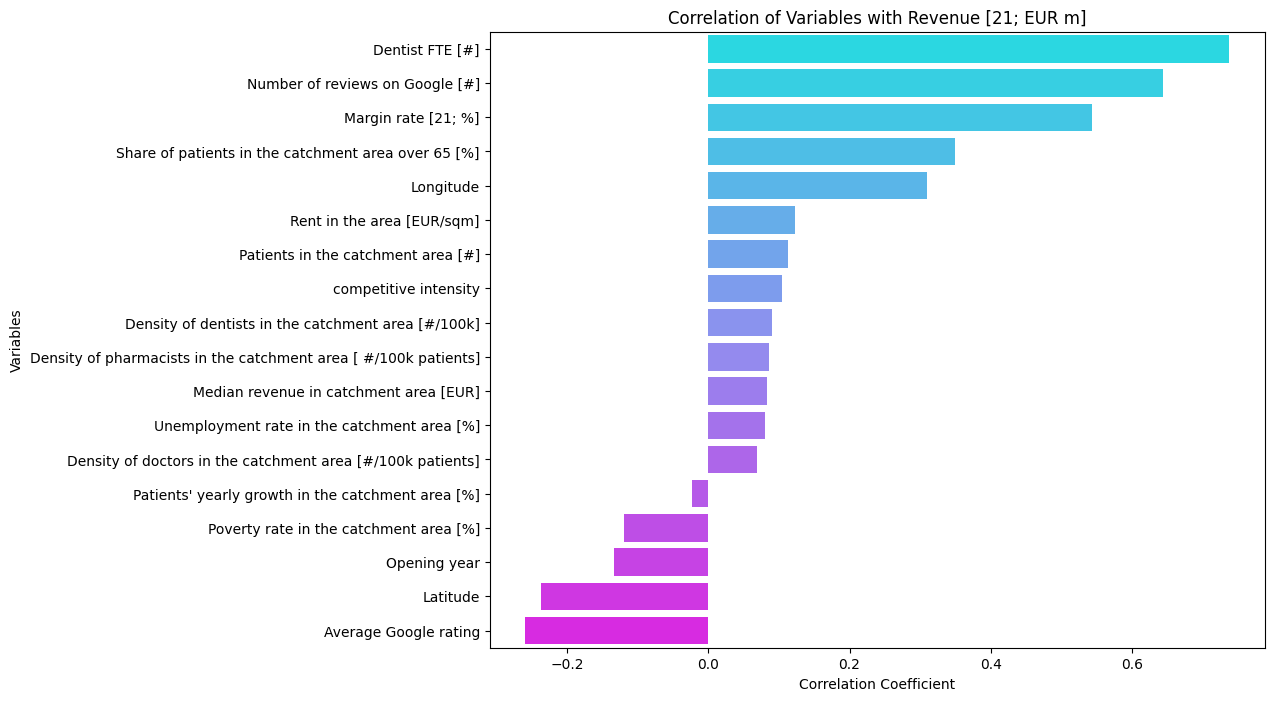

In [79]:
target = 'Revenue [21; EUR m]'
# Calculate correlations of all variables with the target
correlation_matrix = new_data.corr()
correlation_with_target = correlation_matrix[target].drop(target).sort_values(ascending=False)

# Display correlations with the target
plt.figure(figsize=(10, 8))
sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index, palette="cool", legend=False,hue=correlation_with_target.index)
plt.title(f"Correlation of Variables with {target}")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Variables")
plt.show()


competitive intensity represent slight positive correlation with performance.

In [80]:
# Prepare data for modeling
X = new_data.drop(columns=[target])
y = new_data[target]

# Initialize models
linear_model = LinearRegression()
ridge_model = Ridge(alpha=1.0) 

# Train models on the entire dataset
linear_model.fit(X, y)
ridge_model.fit(X, y)

# Predictions on the training set
y_pred_linear = linear_model.predict(X)
y_pred_ridge = ridge_model.predict(X)

# Performance metrics
performance = pd.DataFrame({
    "Model": ["Linear Regression", "Ridge Regression"],
    "Mean Squared Error (MSE)": [
        mean_squared_error(y, y_pred_linear),
        mean_squared_error(y, y_pred_ridge),
    ],
    "Mean Absolute Error (MAE)": [
        mean_absolute_error(y, y_pred_linear),
        mean_absolute_error(y, y_pred_ridge),
    ],
    "R-squared (R²)": [
        r2_score(y, y_pred_linear),
        r2_score(y, y_pred_ridge),
    ],
})

# Display performance metrics
performance

Model  Mean Squared Error (MSE)  Mean Absolute Error (MAE)  \
0  Linear Regression                  0.267069                   0.403065   
1   Ridge Regression                  0.267094                   0.403001   

   R-squared (R²)  
0        0.828817  
1        0.828801

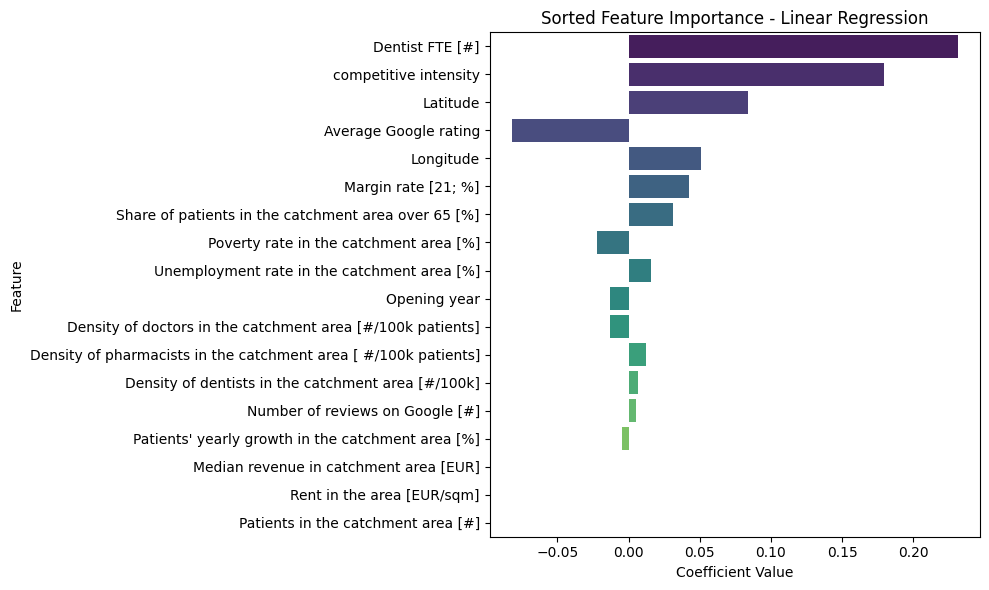

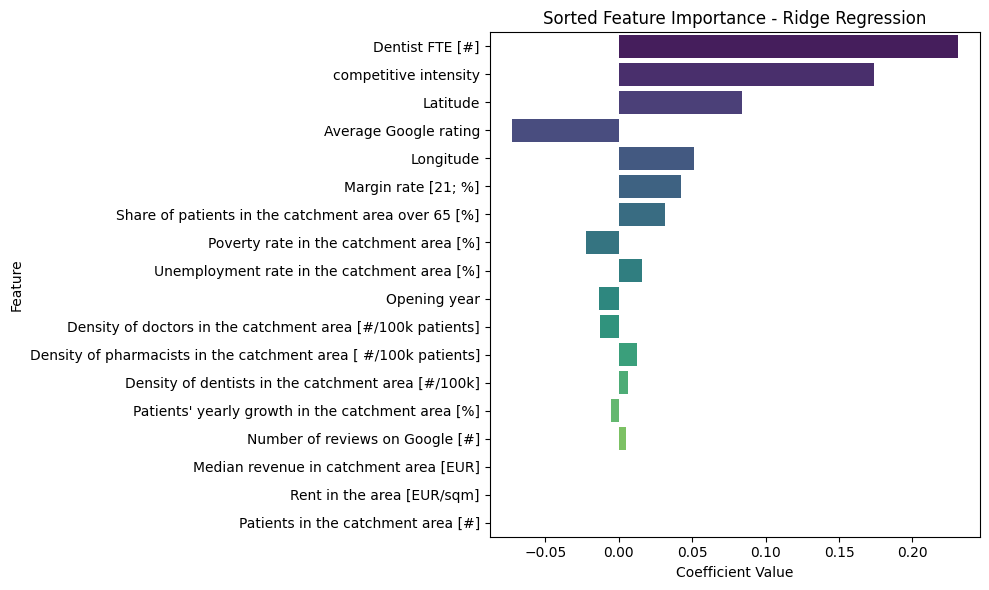

In [81]:
# Function to plot sorted feature importance
def plot_sorted_feature_importance(coefficients, model_name):
    importance_df = pd.DataFrame({
        "Feature": X.columns,
        "Coefficient": coefficients
    }).sort_values(by="Coefficient", key=np.abs, ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importance_df["Coefficient"], y=importance_df["Feature"], palette="viridis", legend=False, hue=importance_df["Feature"])
    plt.xlabel("Coefficient Value")
    plt.ylabel("Feature")
    plt.title(f"Sorted Feature Importance - {model_name}")
    plt.tight_layout()
    plt.show()

# Plot feature importance for each model
plot_sorted_feature_importance(linear_model.coef_, "Linear Regression")
plot_sorted_feature_importance(ridge_model.coef_, "Ridge Regression")

* Observation:
Interestingly, we found a positive correlation between competitive intensity and revenue. Initially, it was expected that more competitors would result in lower revenues, as competition typically divides market share. However, the results reveal a different pattern.

* Marketing Insight:
This finding aligns with a known marketing principle: the presence of competitors in close proximity can create a market concentration effect. When multiple centers exist in the same area, they collectively attract more clients, as potential customers are more likely to choose the area when they have multiple options. The decision is no longer whether to visit the area but rather which center to choose once there.

* Balanced Competition:
However, the positive correlation is not infinite. The analysis suggests there is an optimal level of competition:

-Having too few competitors may fail to create the market concentration effect, resulting in lower revenues.

-Having too many competitors may oversaturate the market, causing revenue to diminish.

### Reviewing question 3

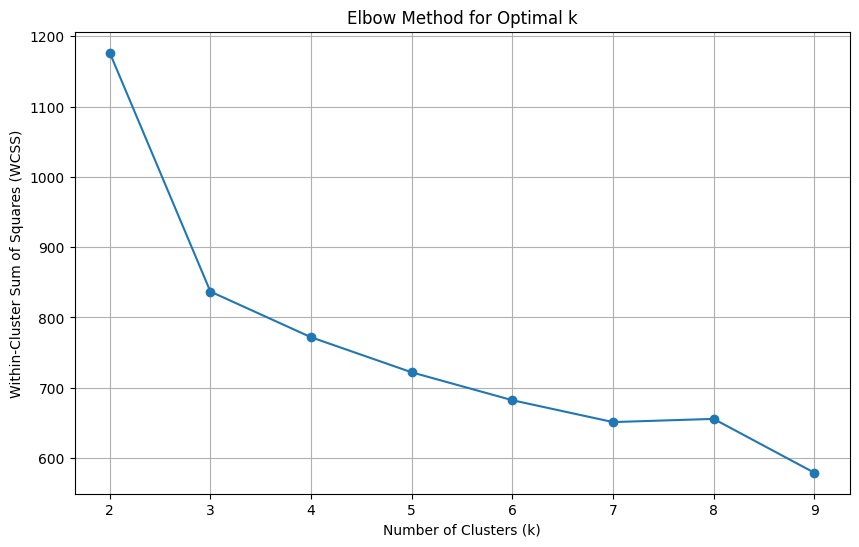

In [82]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(new_data)

# Test different numbers of clusters
wcss = []
silhouette_scores = []
k_values = range(2, 10)  # Testing from 2 to 9 clusters

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=27)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)  # Sum of squared distances within clusters
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot the Elbow Method (WCSS)
plt.figure(figsize=(10, 6))
plt.plot(k_values, wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(k_values)
plt.grid(True)
plt.show()


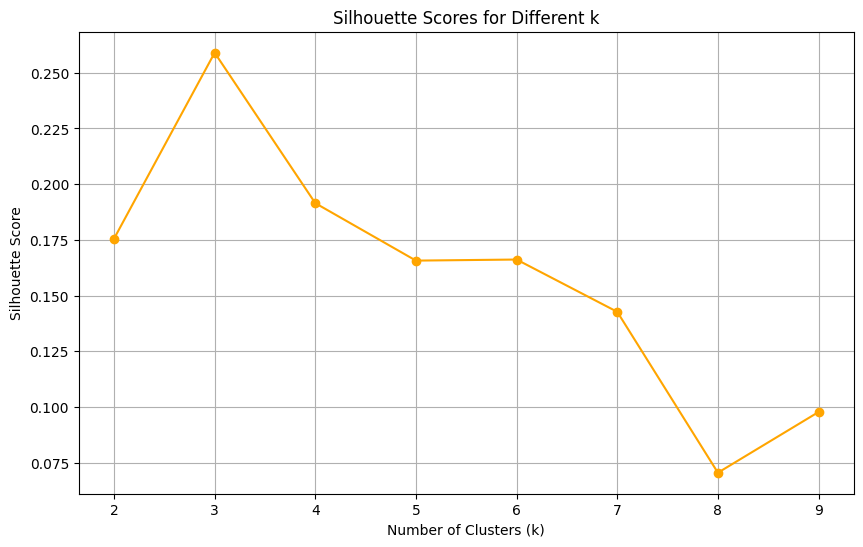

In [83]:
# Plot the Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Scores for Different k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [84]:
# Use K-Means to cluster the data
kmeans = KMeans(n_clusters=3, random_state=10)  # Start with 3 clusters
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to the a new dataframe
df_clustered = new_data.copy()
df_clustered['Cluster'] = clusters

df_clustered['Cluster'].value_counts()


Cluster
0    36
2    18
1    17
Name: count, dtype: int64

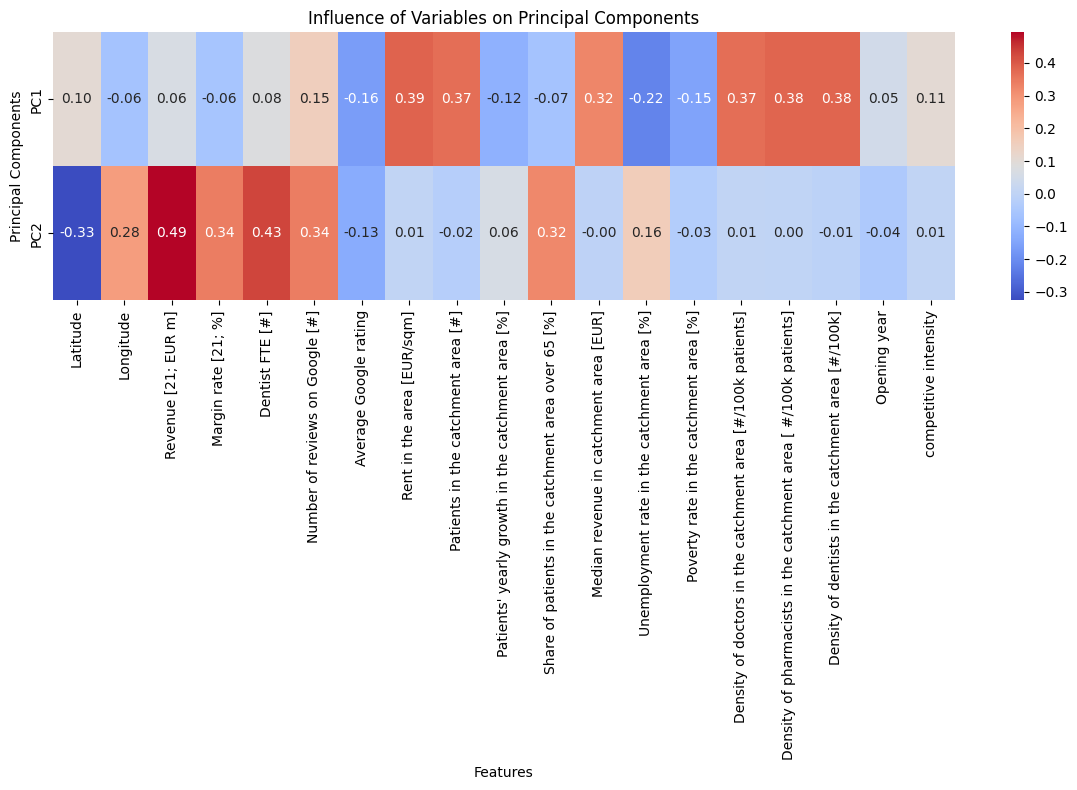

In [85]:
# Perform PCA for visualization (reduce to 2 components)
pca = PCA(n_components=2, random_state=53)
X_pca = pca.fit_transform(X_scaled)

# Analyze the influence of each variable on the principal components
pca_components = pd.DataFrame(
    pca.components_,
    columns=new_data.select_dtypes(include=[float, int]).columns,
    index=[f"PC{i+1}" for i in range(pca.n_components_)]
)

# Visualize the influence of variables on the first two principal components
plt.figure(figsize=(12, 8))
sns.heatmap(pca_components, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Influence of Variables on Principal Components")
plt.xlabel("Features")
plt.ylabel("Principal Components")
plt.tight_layout()
plt.show()



We can see that the competitive intensity is considered as an external factor (contributing to PC1)

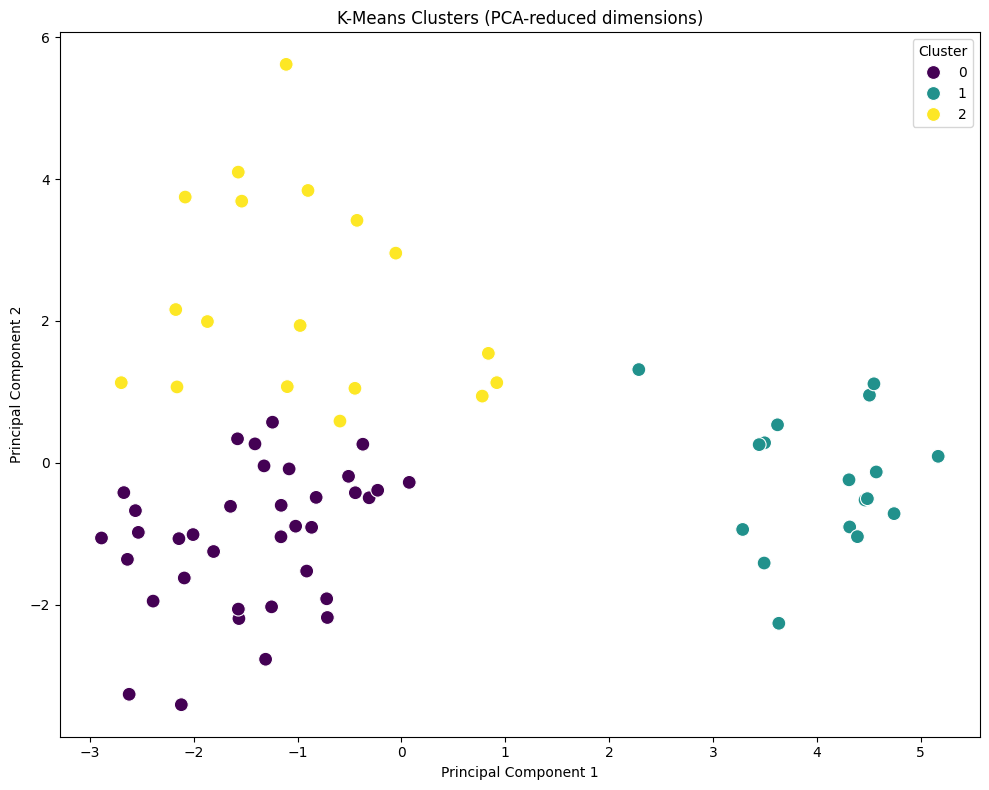

In [86]:
# Add PCA components to the dataframe for visualization
df_clustered['PCA1'] = X_pca[:, 0]
df_clustered['PCA2'] = X_pca[:, 1]

# Visualize the clusters in 2D
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df_clustered, palette='viridis', s=100)
plt.title('K-Means Clusters (PCA-reduced dimensions)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', loc='best')
plt.tight_layout()
plt.show()


In [89]:
cluster_summary = df_clustered.groupby('Cluster').mean().drop(columns=['PCA1', 'PCA2'])

cluster_summary[['Revenue [21; EUR m]', 'Patients in the catchment area [#]', "Patients' yearly growth in the catchment area [%]", 'competitive intensity']]

Revenue [21; EUR m]  Patients in the catchment area [#]  \
Cluster                                                            
0                   1.358502                        48013.791137   
1                   2.341176                       178821.971007   
2                   3.361195                        48383.600105   

         Patients' yearly growth in the catchment area [%]  \
Cluster                                                      
0                                                 0.215556   
1                                                -0.415882   
2                                                 0.548333   

         competitive intensity  
Cluster                         
0                     0.583333  
1                     1.000000  
2                     0.611111

The cluster with moderate competitive intensity (Cluster 2) outperformed others in terms of revenue. This reinforces the idea that:

* Low Competition (Cluster 0): Fails to attract enough clients due to a lack of market concentration.
* High Competition (Cluster 1): Leads to diminishing returns as the market becomes oversaturated.
* Moderate Competition (Cluster 2): Strikes the right balance, creating enough market pull while keeping oversaturation in check.

*Implications*

* Strategic Placement:

When opening new centers, aim for areas with moderate competitive intensity. These areas are likely to yield the best revenues, as they attract sufficient demand without being oversaturated.

* Performance Optimization:

Centers in areas with low competition may benefit from marketing strategies to increase local visibility and draw clients from neighboring areas.

Centers in areas with high competition could focus on differentiation strategies (e.g., better customer service, specialized treatments) to capture a larger share of the local market.

*Conclusion*

This reanalysis demonstrates that competitive intensity significantly influences performance. The interplay between competition and revenue is nuanced:

Having some competition fosters a healthy market environment and improves performance.

Oversaturation, however, diminishes returns.

## Question 7

**Summarize your findings** in business terms and formulate a recommendation on how to improve the overall dental center network performance based on the answers to the previous questions.

**Note: for this question no code is expected**

-------------

### Summary of Findings :

Based on our analysis across all questions, we have derived actionable insights to improve the performance of the dental center network. Here's a summary of our findings:

#### Key Drivers of Performance (Question 2) :

* Internal Factors as the Primary Drivers:

Dentist FTE (#), Number of Google reviews, and Margin rate (%) are the strongest predictors of revenue, emphasizing the importance of operational efficiency and customer engagement.

Centers with higher staffing levels and stronger online presence tend to perform better.
* Role of External Factors:

External factors like Patients in the catchment area and Share of patients over 65 show moderate importance, indicating that while demographics matter, they are less influential than internal factors.
* Competitive Intensity:

Interestingly, competitive intensity shows a positive correlation with revenue, but only up to a point. Moderate levels of competition enhance performance by creating market concentration, while oversaturation diminishes returns.
Segmentation of Centers (Question 3)

#### Using clustering analysis, we identified three distinct clusters of centers:

* Cluster 0: Moderate Performers:

Centers with low revenue and low competitive intensity.

Typically located in regions with lower patient density and higher elderly populations.

**Recommendation**: Focus on operational improvements and marketing strategies to boost customer engagement and visibility.
* Cluster 1: High-Demand Urban Centers:

Centers with moderate revenue, operating in high-cost, high-density urban areas.

These centers face intense competition but tend to underperform in customer satisfaction metrics (e.g., Google ratings).

**Recommendation**: Improve patient experience and differentiate services to gain a competitive edge in saturated markets.
* Cluster 2: Top Performers:

Centers with the highest revenue and profitability, operating in areas with moderate competitive intensity and affluent demographics.

**Recommendation**: Maintain operational excellence while exploring premium service offerings or expanding into similar markets.

#### Impact of Competitive Intensity (Question 6)
* Market Concentration Effect:

Moderate competition fosters a healthy market environment, attracting more customers to the area and benefiting all centers.
* Balanced Competition:

Too few competitors fail to create market pull, while too many dilute revenue potential.

Centers in areas with moderate competitive intensity (Cluster 2) achieved the best performance, demonstrating the importance of strategic placement.

#### Recommendations for Network Performance Improvement
* Strategic Expansion:

When opening new centers, prioritize areas with moderate competitive intensity and favorable demographics to maximize revenue potential.

Avoid markets with either low competition (insufficient demand) or high competition (oversaturated).
* Operational Excellence:

Invest in staffing levels and ensure high-quality service delivery to boost operational efficiency.

Strengthen online presence by encouraging customer reviews and maintaining high Google ratings.
* Localized Strategies:

For low-performing centers in areas with low competition, focus on increasing visibility through targeted marketing campaigns.

In highly competitive areas, differentiate services through innovation (e.g., specialized treatments) and enhanced patient experiences.
* Monitor Competitive Intensity:

Regularly assess competitive intensity and its impact on center performance to identify emerging opportunities or threats.
* Cluster-Based Actions:

Tailor strategies to the unique needs of each cluster:

-Moderate Performers: Operational optimization.

-High-Demand Urban Centers: Cost management and differentiation.

-Top Performers: Growth and premium service offerings.


#### Conclusion
By focusing on the key drivers of performance—internal factors, market dynamics, and competitive intensity—the dental clinic chain can make informed decisions to optimize the performance of existing centers and strategically expand its network. Leveraging these insights will enable the chain to achieve sustainable growth and maintain a competitive edge in the market.